# Script for analyzing flexibility of DNA segments

## Are DNA section containing clustered transposons or transposons in general more flexible?

In [1]:
import pandas as pd
import pyBigWig
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy
from scipy.ndimage import gaussian_filter
import sklearn
from sklearn.neighbors import KernelDensity
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from collections import Counter, defaultdict
import concurrent.futures
from multiprocessing import Pool, cpu_count
import pickle
import pysam

# Load in transposon data

Detection of Transposons in genome:

repeat masker from UCSC:

https://genome.ucsc.edu/cgi-bin/hgTrackUi?g=rmsk

https://genome.ucsc.edu/cgi-bin/hgTables?hgta_doMainPage=1&hgta_group=varRep&hgta_track=rmsk&hgta_table=rmsk&hgsid=1409663405_4aL7oZASpQ7rZ6grjKWGJNHJPUAe&source=post_page-----2b32f6b67364--------------------------------

uses data from repeatmasker: https://www.repeatmasker.org/genomicDatasets/RMGenomicDatasets.html

#Alternative names of chromosomes: https://genome.ucsc.edu/FAQ/FAQdownloads.html#downloadAlt

"The chr_alt chromosomes, such as chr5_KI270794v1_alt, are alternative sequences that differ from the reference genome currently available..."

"The chr_fix chromosomes, such as chr1_KN538361v1_fix, are fix patches currently available for the mm10, hg19, and hg38 assemblies that represent changes to the existing sequence..."

"ChrUn contains clone contigs that cannot be confidently placed on a specific chromosome..."

"ChrN_random: ...data related to sequence that is known to be in a particular chromosome, but could not be reliably ordered within the current sequence..."

"What is chromosome M (chrM)? "Mitochondrial DNA.

etc...

Annotation of Lines https://www.repeatmasker.org/faq.html: Since LINE copies tend to be 5' truncated, full-length models of the detailed subfamily structure apparent in the well-represented and fast-evolving 3' end are difficult to obtain. Rather than comparing the query to a large number of full-length (6-8 kb) consensus sequences that are identical except for the very 3' end, we often fragment LINE models into domains (e.g. 5' end, ORF2-region, and 3' end) which are transparently merged in the RepeatMasker annotation as if the matching was done to a full-length consensus. Our nomenclature and fragmentation thus create a many-to-one relationship with Repbase full-length entries.

https://www.animalgenome.org/bioinfo/resources/manuals/RepeatMasker.html


In [2]:
#repeat masker files
fields_sel=["genoName","genoStart","genoEnd","repName","repClass","repFamily"]
rmd=pd.read_csv("Transposon_analysis_1/hg19_all_fields_repeat_masker",sep="\t",header = 0,usecols=fields_sel)



In [3]:
rmd

genoName  genoStart   genoEnd     repName repClass  \
0                         chr1   16777160  16777470       AluSp     SINE   
1                         chr1   25165800  25166089        AluY     SINE   
2                         chr1   33553606  33554646         L2b     LINE   
3                         chr1   50330063  50332153      L1PA10     LINE   
4                         chr1   58720067  58720973       L1PA2     LINE   
...                        ...        ...       ...         ...      ...   
5481336  chr21_gl000210_random      25378     25875      MER74B      LTR   
5481337  chr21_gl000210_random      26437     26596        MIRc     SINE   
5481338  chr21_gl000210_random      26881     27022        MIRc     SINE   
5481339  chr21_gl000210_random      27296     27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468     27682  HAL1-2a_MD     LINE   

        repFamily  
0             Alu  
1             Alu  
2              L2  
3              L1  
4              L1  
...           ...  
5481336      ERVL  
5481337       MIR  
5481338       MIR  
5481339        L1  
5481340        L1  

[5481341 rows x 6 columns]

In [4]:
#Names of sub-families
unique = [rmd[col_name].unique() for col_name in rmd.columns]

for i in unique[3]:
    print(i)

AluSp
AluY
L2b
L1PA10
L1PA2
L1MB7
ERVL-E-int
L2a
L1ME1
L1PA7
L1PA3
AluSq2
HSMAR2
MLT1J
MIRb
THE1B
AluSx1
MER58A
LTR12C
MIR3
L1ME2
L3
AluSc
L2
AluJb
L1MEc
Charlie1b
AluSx
MIRc
MER21C
AluSx4
L4
L1MA9
AT_rich
L2c
L1MB3
THE1B-int
MER58B
AluJr
MamRep1527
MIR
THE1D
SVA_D
FRAM
AluSg
LTR47B
L1PA8A
AluJo
MER6B
LTR76
L1PA6
LTR85c
L1M2
Mam_R4
HAL1
L1PA14
AluSz
L1MA10
L1M1
(CA)n
L1ME3
L1PBa
L1PA15-16
MLT2B4
MER21A
MLT1F2
L1M4
AluSc8
Arthur1
L1MDa
MLT1M
LTR24C
MER65D
Charlie25
MLT1B
HERVH-int
MER58D
L1MC4
L1ME4a
Tigger3a
L1MB8
MER20
(CAAAA)n
MER52-int
HERVK-int
LTR7B
MLT1H
LTR37A
(TA)n
LTR38B
MER39
MLT1A0
MER11C
L1MC
LTR7C
MER5B
AluSz6
MER53
AluSx3
SVA_F
MLT1L
GA-rich
L1M3
MER41B
Tigger1
(GAA)n
L1MC1
MLT1I
L1PA5
L1PA4
LTR33
MER33
L1MC3
FLAM_C
AluJr4
L1M5
Harlequin-int
L1PA15
LTR16A
L1MA1
MER41-int
L1PA17
L1PB4
L1M4b
L1PB1
L1PA13
L1MB1
HERVI-int
MLT1E1A
MLT1C
MER82
MamGypLTR1b
L1MA7
LTR85a
L1MB2
L1PA8
MLT2A1
MLT1J1-int
L1P1
LTR16A1
MER31-int
LTR1B
(TG)n
THE1A-int
MLT1D
HERVL32-int
L1MA3
ERVL-B4-int


# Load subset of repeat masker data, subfamily positions, on each chromosome

## Functions

In [5]:
#function to select repetitive elements
def sel_rep_element_on_chr(rmd_1,chr_list,elements_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[0]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx.iloc[:,3].str.startswith(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list

def sel_rep_element_on_chr_2(rmd_1,chr_list,elements_name,chr_col_name,element_col_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[chr_col_name]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx[element_col_name].str.fullmatch(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list


##################
##################

#get positions and length of elements
def positions_elements_2_b(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    len_element=[]
    for i in range(len(rmd_input)):
        len_1=rmd_input[i:i+1]["genoEnd"].to_numpy()[0]-rmd_input[i:i+1]["genoStart"].to_numpy()[0]
        pos_1=rmd_input[i:i+1]["genoStart"].to_numpy()[0] + 0.5*len_1
        
        pos.append(pos_1)
        len_element.append(len_1)
    return np.asarray(pos), np.asarray(len_element)

#get positions and lengths of elements and pariwise distances for each entry in chr_list, and same for random positions
def get_pos_dist_2(chr_list,rmd_list):
    #list of positions
    pos_x_list=[]
    #list of lengths
    len_x_list=[]
    #list of uniformly distributed positions
    pos_rd_x_list=[]

    #list of pairwise distances in each chromosome
    dist_x_list=[]
    #list of pairwise distances from uniformly distributed elements
    dist_rd_x_list=[]
    for i in range(len(chr_list)):
        #print(chr_list[i])
        positions_elements_x,lenghts_elements_x=positions_elements_2_b(rmd_list[i])
        pos_x_list.append(positions_elements_x)
        len_x_list.append(lenghts_elements_x)
        
        '''dist_x = np.empty((len(positions_elements_x),len(positions_elements_x)))
        for i in range(len(positions_elements_x)):
            dist_x[i, :] = ((positions_elements_x.reshape(-1,1)-positions_elements_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_x=dist_x[np.triu_indices(len(positions_elements_x),k=1)]'''
        #return D
        dist_x=scipy.spatial.distance.pdist(positions_elements_x.reshape(-1,1),metric='euclidean')
        #dist_x=euclidean_distances(positions_elements_x.reshape(-1,1),positions_elements_x.reshape(-1,1))[np.triu_indices(len(positions_elements_x),k=1)]
        dist_x_list.append(np.asarray(dist_x) )

        #uniformly distributed positions in intervall [min_pos, max_pos], number =  number of elements on chr. from rep. masker subset
        positions_random_x=np.random.choice(np.arange(np.min(positions_elements_x),np.max(positions_elements_x),step=0.5),size=len(positions_elements_x))
        '''dist_rd_x = np.empty((len(positions_random_x),len(positions_random_x)))
        for i in range(len(positions_random_x)):
            dist_rd_x[i, :] = ((positions_random_x.reshape(-1,1)-positions_random_x.reshape(-1,1)[i])**2).sum(axis=1)**0.5
            
        dist_rd_x=dist_rd_x[np.triu_indices(len(positions_random_x),k=1)]'''
        pos_rd_x_list.append(positions_random_x)
        dist_rd_x=scipy.spatial.distance.pdist(positions_random_x.reshape(-1,1),metric='euclidean')
        #dist_rd_x=euclidean_distances(positions_random_x.reshape(-1,1),positions_random_x.reshape(-1,1))[np.triu_indices(len(positions_random_x),k=1)]

        dist_rd_x_list.append(np.asarray(dist_rd_x))
    return pos_x_list,len_x_list, pos_rd_x_list, dist_x_list, dist_rd_x_list


#create df from chr_list, pos_list and len_list with id, chrom, start, stop, columns
def df_for_rd_positions_V1(chr_list, pos_rd_x_list, len_x_list):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)):
        #get chr
        chr_sel_list=[]
        rd_start_list=[]
        rd_stop_list=[]
        rd_id_list=[]
        count_1=0
    
        chr_sel=chr_list[i]
        for j in range(len(pos_rd_x_list[i])):
            #get pos
            start_sel=int(np.round(pos_rd_x_list[i][j]-len_x_list[i][j]/2 ,0))
            stop_sel=int(np.round(pos_rd_x_list[i][j]+len_x_list[i][j]/2 ,0))
            
            chr_sel_list.append(chr_sel)
            rd_start_list.append(start_sel)
            rd_stop_list.append(stop_sel)
            rd_id_list.append(count_1)
            count_1=count_1+1
            
        all_data={col_create[0]:rd_id_list,
             col_create[1]:chr_sel_list,
             col_create[2]:rd_start_list,
             col_create[3]:rd_stop_list}  
    
        df_rd=pd.DataFrame(all_data)
        df_rd_list.append(df_rd)
    return df_rd_list

## Load data for transposons and control elements

In [6]:
#split read-in into chromosomes
#no chrY to compare to HeLa cells
chr_list=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22","chrX"
         ]
#select the sub-family for analysis
element_sel_1="L1ME1"#"L1ME1" #"L1ME1" #"MamRep1527"  #"MamRep1527" #"L1ME1" #"AluSp"
element_sel_2="AluSp"

element_sel_3="L2"
element_sel_4="L2b"


In [ ]:
#annotation for sub-family elements, split into chromosomes
rmd_list_1= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=element_sel_1,chr_col_name="genoName",element_col_name="repName")

#get total number of elements
len_rmd_list_1=0
for i in range(len(rmd_list_1)):
    len_rmd_list_1=len_rmd_list_1+len(rmd_list_1[i])
print("Total number of elements loaded:",len_rmd_list_1)

#get centre position and lengths of elements and control elements placed randomly from uniform distribution
pos_x_list_1,len_x_list_1, pos_rd_x_list_1, dist_x_list_1, dist_rd_x_list_1 = get_pos_dist_2(chr_list=chr_list,rmd_list=rmd_list_1)


#create a data frame with random, hom. distr. points (have same lengths as transposons)
rmd_rd_list_1=df_for_rd_positions_V1(chr_list=chr_list, pos_rd_x_list=pos_rd_x_list_1, len_x_list=len_x_list_1)


In [26]:
#annotation for sub-family elements, split into chromosomes
rmd_list_2= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=element_sel_2,chr_col_name="genoName",element_col_name="repName")

#get total number of elements
len_rmd_list_2=0
for i in range(len(rmd_list_2)):
    len_rmd_list_2=len_rmd_list_2+len(rmd_list_2[i])
print("Total number of elements loaded:",len_rmd_list_2)

#get centre position and lengths of elements and control elements placed randomly from uniform distribution
pos_x_list_2,len_x_list_2, pos_rd_x_list_2, dist_x_list_2, dist_rd_x_list_2 = get_pos_dist_2(chr_list=chr_list,rmd_list=rmd_list_2)


#create a data frame with random, hom. distr. points (have same lengths as transposons)
rmd_rd_list_2=df_for_rd_positions_V1(chr_list=chr_list, pos_rd_x_list=pos_rd_x_list_2, len_x_list=len_x_list_2)

Total number of elements loaded: 54002


In [9]:
#annotation for sub-family elements, split into chromosomes
rmd_list_3= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=element_sel_3,chr_col_name="genoName",element_col_name="repName")

#get total number of elements
len_rmd_list_3=0
for i in range(len(rmd_list_3)):
    len_rmd_list_3=len_rmd_list_3+len(rmd_list_3[i])
print("Total number of elements loaded:",len_rmd_list_3)

#get centre position and lengths of elements and control elements placed randomly from uniform distribution
pos_x_list_3,len_x_list_3, pos_rd_x_list_3, dist_x_list_3, dist_rd_x_list_3 = get_pos_dist_2(chr_list=chr_list,rmd_list=rmd_list_3)


#create a data frame with random, hom. distr. points (have same lengths as transposons)
rmd_rd_list_3=df_for_rd_positions_V1(chr_list=chr_list, pos_rd_x_list=pos_rd_x_list_3, len_x_list=len_x_list_3)

Total number of elements loaded: 55753


In [10]:
#annotation for sub-family elements, split into chromosomes
rmd_list_4= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=element_sel_4,chr_col_name="genoName",element_col_name="repName")

#get total number of elements
len_rmd_list_4=0
for i in range(len(rmd_list_4)):
    len_rmd_list_4=len_rmd_list_4+len(rmd_list_4[i])
print("Total number of elements loaded:",len_rmd_list_4)

#get centre position and lengths of elements and control elements placed randomly from uniform distribution
pos_x_list_4,len_x_list_4, pos_rd_x_list_4, dist_x_list_4, dist_rd_x_list_4 = get_pos_dist_2(chr_list=chr_list,rmd_list=rmd_list_4)


#create a data frame with random, hom. distr. points (have same lengths as transposons)
rmd_rd_list_4=df_for_rd_positions_V1(chr_list=chr_list, pos_rd_x_list=pos_rd_x_list_4, len_x_list=len_x_list_4)

Total number of elements loaded: 97101


In [18]:
rmd_list_1

[       genoName  genoStart    genoEnd repName repClass repFamily
 8          chr1  117440426  117440514   L1ME1     LINE        L1
 9          chr1  117440494  117441457   L1ME1     LINE        L1
 62         chr1  114294558  114295009   L1ME1     LINE        L1
 63         chr1  116391804  116391994   L1ME1     LINE        L1
 103        chr1  216004377  216007947   L1ME1     LINE        L1
 ...         ...        ...        ...     ...      ...       ...
 431113     chr1  247939643  247940146   L1ME1     LINE        L1
 431117     chr1  247941299  247941531   L1ME1     LINE        L1
 431120     chr1  247943689  247943971   L1ME1     LINE        L1
 431122     chr1  247944179  247944276   L1ME1     LINE        L1
 432651     chr1  249126262  249126531   L1ME1     LINE        L1
 
 [2527 rows x 6 columns],
        genoName  genoStart    genoEnd repName repClass repFamily
 432872     chr2    4194280    4195111   L1ME1     LINE        L1
 432949     chr2  191889374  191889503   L1ME1  

## Save and load transposon and control element positions

In [27]:
with open ("Transposon_analysis_1/save_elements/AluJr_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_list_1,f)
with open ("Transposon_analysis_1/save_elements/AluJr_rd_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_rd_list_1,f)
    
with open ("Transposon_analysis_1/save_elements/AluSq2_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_list_2,f)
with open ("Transposon_analysis_1/save_elements/AluSq2_rd_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_rd_list_2,f)
    
with open ("Transposon_analysis_1/save_elements/L2_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_list_3,f)
with open ("Transposon_analysis_1/save_elements/L2_rd_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_rd_list_3,f)
    
with open ("Transposon_analysis_1/save_elements/L2b_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_list_4,f)
with open ("Transposon_analysis_1/save_elements/L2b_rd_pos_V1.pkl","wb") as f:
    pickle.dump(rmd_rd_list_4,f)

'    \nwith open ("Transposon_analysis_1/save_elements/L2_pos_V1.pkl","wb") as f:\n    pickle.dump(rmd_list_3,f)\nwith open ("Transposon_analysis_1/save_elements/L2_rd_pos_V1.pkl","wb") as f:\n    pickle.dump(rmd_rd_list_3,f)\n    \nwith open ("Transposon_analysis_1/save_elements/L2b_pos_V1.pkl","wb") as f:\n    pickle.dump(rmd_list_4,f)\nwith open ("Transposon_analysis_1/save_elements/L2b_rd_pos_V1.pkl","wb") as f:\n    pickle.dump(rmd_rd_list_4,f)'

In [7]:
with open('Transposon_analysis_1/save_elements/L1ME1_pos_V1.pkl', 'rb') as f:
    rmd_list_1 = pickle.load(f)
with open('Transposon_analysis_1/save_elements/L1ME1_rd_pos_V1.pkl', 'rb') as f:
    rmd_rd_list_1 = pickle.load(f)
    
with open('Transposon_analysis_1/save_elements/L1HS_pos_V1.pkl', 'rb') as f:
    rmd_list_2 = pickle.load(f)
with open('Transposon_analysis_1/save_elements/L1HS_rd_pos_V1.pkl', 'rb') as f:
    rmd_rd_list_2 = pickle.load(f)


with open('Transposon_analysis_1/save_elements/AluSp_pos_V1.pkl', 'rb') as f:
    rmd_list_3 = pickle.load(f)
with open('Transposon_analysis_1/save_elements/AluSp_rd_pos_V1.pkl', 'rb') as f:
    rmd_rd_list_3 = pickle.load(f)


with open('Transposon_analysis_1/save_elements/AluY_pos_V1.pkl', 'rb') as f:
    rmd_list_4 = pickle.load(f)
with open('Transposon_analysis_1/save_elements/AluY_rd_pos_V1.pkl', 'rb') as f:
    rmd_rd_list_4 = pickle.load(f)

# TRX scores of DNA sections

## Functions

In [8]:
#there are 16 permutations of dinucleotide steps using A C G T
#However, only 10 unique dinucleotides, in 5'->3' direction 
#when picturing linear seq with complement, the following linear seq are the same: GG = CC, AA = TT  -> onl 14 left
#same for these: AC = GT, GA = TC, AG = CT,CA = TG -> only 10 left
#important: taking 5'->3' direction into account
#(originally CpG notation, here written as CG)

#both fasta files read in with pysam and repeat masker annotation use 0 based indexing (5'->3')

#TRX values from table 1 in Heddi et al 2009: https://pmc.ncbi.nlm.nih.gov/articles/PMC2817485/#T1
TRX_values = {
    'CG': 43,
    'CA': 42,
      'TG': 42,
    'GG': 42,
      'CC': 42,
    'GC': 25,
    'GA': 22,
      'TC': 22,
    'TA': 14,
    'AG': 9,
      'CT': 9,
    'AA': 5,
      'TT': 5,
    'AC': 4,
      'GT': 4,
    'AT': 0

}
#calculate the mean TRX score of a string 
def calculate_TRX(sequence):
    sequence = sequence.upper() # want capitalized version, in fasta file repeat elements are lower case
    TRX_scores = []
    #iterate over sequence, use slices of two letters for TRX value
    for i in range(len(sequence) - 1):
        dinucleotide = sequence[i:i+2]
        if dinucleotide in TRX_values:
            TRX_scores.append(TRX_values[dinucleotide])
        #else:
         #   print(f"Warning: Dinucleotide {dinucleotide} not found in TRX values.")
    
    if TRX_scores:
        TRX_scores = np.array(TRX_scores)
        mean_TRX = np.mean(TRX_scores, axis=0)
        return mean_TRX
    else:
        return None
        
#apply mean TRX calculation to entries in DataFrame df, use DNA seq from fasta file in reference_genome
def calculate_TRX_for_df(df, reference_genome,chr_name,start_name, end_name):
    #calculate TRX score for rows with chr_name, start_name and end_name of sequence and add it in new column

    #open the reference genome file
    fasta = pysam.FastaFile(reference_genome)
    
    #function to get sequence from fasta and calculate TRX score for a single row in df
    def get_TRX_score(row):
        chrom = row[chr_name]
        start = row[start_name]
        end = row[end_name]
        sequence = fasta.fetch(chrom, start, end)
        return calculate_TRX(sequence)
    
    #apply the function to each row in the DataFrame
    df['TRX_score'] = df.apply(get_TRX_score, axis=1)
    
    return df

#count occurence of dinucleotides in sequence
def count_dinucleotides_in_sequence(sequence):
    dinucleotide_counts = defaultdict(int)
    dinucleotides = [a+b for a in 'ACGT' for b in 'ACGT']
    
    #initialize counts for all dinucleotides
    for dinucleotide in dinucleotides:
        dinucleotide_counts[dinucleotide] = 0

    sequence = sequence.upper()  # Convert to uppercase
    for i in range(len(sequence) - 1):
        dinucleotide = sequence[i:i+2]
        if dinucleotide in dinucleotide_counts:
            dinucleotide_counts[dinucleotide] += 1
    return dinucleotide_counts
    
#merge counts after parallelization
def merge_counts(counts_list):
    merged_counts = defaultdict(int)
    for counts in counts_list:
        for dinucleotide, count in counts.items():
            merged_counts[dinucleotide] += count
    return merged_counts
    
#parallelize count
def count_dinucleotides_parallel(fasta_file, chromosomes):
    fasta = pysam.FastaFile(fasta_file)
    sequences = [fasta.fetch(seq_name) for seq_name in fasta.references if seq_name in chromosomes]
    
    with Pool(cpu_count()) as pool:
        counts_list = pool.map(count_dinucleotides_in_sequence, sequences)
    
    return merge_counts(counts_list)

def get_chromosomes(fasta_file):
    fasta = pysam.FastaFile(fasta_file)
    chromosomes = fasta.references
    return chromosomes

def avg_TRX_from_di_nu_count(dinucleotide_counts_all_chr,tot_num_di_nu):
    avg_TRX=0
    for keys, values in dinucleotide_counts_all_chr.items():
        #print(keys)
        TRX_value=TRX_values[keys]
        di_nu_perc=values /tot_num_di_nu
        avg_TRX=avg_TRX+di_nu_perc*TRX_value
        #print(di_nu_freq)
    return avg_TRX

In [9]:
fasta_test = pysam.FastaFile('Transposon_analysis_1/hg19.fa')

fasta_seq_test=fasta_test.fetch("chr2",200000,200005)
print(fasta_seq_test)

GTCTT


In [10]:
print(calculate_TRX("GTCTT"))
#contains: GT TC CT TT -> 4 + 22 + 9 + 5  =40 -> mean TRX=40/4 =10

10.0


## Get TRX baseline from freq of all dinucleotides in genome

In [6]:
#ceck which chr are available in fasta file, only want chr1-22 +x for evaluation
#hg19 including repeats 
fasta_file = 'Transposon_analysis_1/hg19.fa'
chromosomes = get_chromosomes(fasta_file)
print(chromosomes)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chrX', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr20', 'chrY', 'chr19', 'chr22', 'chr21', 'chr6_ssto_hap7', 'chr6_mcf_hap5', 'chr6_cox_hap2', 'chr6_mann_hap4', 'chr6_apd_hap1', 'chr6_qbl_hap6', 'chr6_dbb_hap3', 'chr17_ctg5_hap1', 'chr4_ctg9_hap1', 'chr1_gl000192_random', 'chrUn_gl000225', 'chr4_gl000194_random', 'chr4_gl000193_random', 'chr9_gl000200_random', 'chrUn_gl000222', 'chrUn_gl000212', 'chr7_gl000195_random', 'chrUn_gl000223', 'chrUn_gl000224', 'chrUn_gl000219', 'chr17_gl000205_random', 'chrUn_gl000215', 'chrUn_gl000216', 'chrUn_gl000217', 'chr9_gl000199_random', 'chrUn_gl000211', 'chrUn_gl000213', 'chrUn_gl000220', 'chrUn_gl000218', 'chr19_gl000209_random', 'chrUn_gl000221', 'chrUn_gl000214', 'chrUn_gl000228', 'chrUn_gl000227', 'chr1_gl000191_random', 'chr19_gl000208_random', 'chr9_gl000198_random', 'chr17_gl000204_random', 'chrUn_gl000233', 'chrUn_gl000237', 'c

In [6]:
%%time
#hg19 including repeats 
#fasta_file = 'Transposon_analysis_1/hg19.fa'

#for consistency with other data dont use chr Y
chromosomes = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18','chr19', 'chr20','chr21',  'chr22', 'chrX']  # List of chromosomes to include
dinucleotide_counts_all_chr = count_dinucleotides_parallel(fasta_file, chromosomes)
print(dinucleotide_counts_all_chr)

defaultdict(<class 'int'>, {'AA': 277154316, 'AC': 142735270, 'AG': 198321459, 'AT': 218984232, 'CA': 205665280, 'CC': 147813558, 'CG': 27999103, 'CT': 198435457, 'GA': 168236007, 'GC': 121054424, 'GG': 147880867, 'GT': 143033621, 'TA': 186139647, 'TC': 168310286, 'TG': 206003354, 'TT': 277906361})
CPU times: user 7.84 s, sys: 3.45 s, total: 11.3 s
Wall time: 1min 1s


In [7]:
tot_num_di_nu=sum(dinucleotide_counts_all_chr.values())

#test_di={"AA":2,"CG":1}

avg_TRX_all_di_nu=avg_TRX_from_di_nu_count(dinucleotide_counts_all_chr=dinucleotide_counts_all_chr,tot_num_di_nu=tot_num_di_nu)

print("Avg TRX from all dinucleotides:",avg_TRX_all_di_nu)

Avg TRX from all dinucleotides: 18.13986690783888


In [11]:
avg_TRX_all_di_nu=18.13986690783888

# Get TRX for A/B compartment

In [12]:
#https://github.com/ma-compbio/SNIPER?tab=readme-ov-file
#ML based mehtod to assign A/B based on sparse Hi-C data from Rao et al 2014, GSE63525
column_names_AB=["CHROM","START","STOP","Compartment","C5","C6","C7","C8","C9"]
#no X/Y chr
AB_HeLa=pd.read_csv("Transposon_analysis_1/AB_compartments_HeLa/HeLa_A_B.csv", sep=';', header=0,names=column_names_AB)

In [13]:
AB_HeLa

CHROM     START      STOP Compartment  C5 C6        C7        C8  \
0       chr1         0    100000          B1   0  .         0    100000   
1       chr1    100000    200000          B1   0  .    100000    200000   
2       chr1    200000    300000          B1   0  .    200000    300000   
3       chr1    300000    400000          B3   0  .    300000    400000   
4       chr1    400000    500000          B3   0  .    400000    500000   
...      ...       ...       ...         ...  .. ..       ...       ...   
26982  chr22  50800000  50900000          A1   0  .  50800000  50900000   
26983  chr22  50900000  51000000          A1   0  .  50900000  51000000   
26984  chr22  51000000  51100000          A1   0  .  51000000  51100000   
26985  chr22  51100000  51200000          A2   0  .  51100000  51200000   
26986  chr22  51200000  51300000          A2   0  .  51200000  51300000   

                C9  
0        220,20,60  
1        220,20,60  
2        220,20,60  
3      112,128,144  
4      112,128,144  
...            ...  
26982    34,139,34  
26983    34,139,34  
26984    34,139,34  
26985  152,251,152  
26986  152,251,152  

[26987 rows x 9 columns]

In [14]:
AB_HeLa_fA=AB_HeLa[AB_HeLa["Compartment"].str.startswith('A')]

AB_HeLa_fA

CHROM     START      STOP Compartment  C5 C6        C7        C8  \
5       chr1    500000    600000          A2   0  .    500000    600000   
6       chr1    600000    700000          A2   0  .    600000    700000   
7       chr1    700000    800000          A1   0  .    700000    800000   
9       chr1    900000   1000000          A1   0  .    900000   1000000   
10      chr1   1000000   1100000          A1   0  .   1000000   1100000   
...      ...       ...       ...         ...  .. ..       ...       ...   
26982  chr22  50800000  50900000          A1   0  .  50800000  50900000   
26983  chr22  50900000  51000000          A1   0  .  50900000  51000000   
26984  chr22  51000000  51100000          A1   0  .  51000000  51100000   
26985  chr22  51100000  51200000          A2   0  .  51100000  51200000   
26986  chr22  51200000  51300000          A2   0  .  51200000  51300000   

                C9  
5      152,251,152  
6      152,251,152  
7        34,139,34  
9        34,139,34  
10       34,139,34  
...            ...  
26982    34,139,34  
26983    34,139,34  
26984    34,139,34  
26985  152,251,152  
26986  152,251,152  

[13390 rows x 9 columns]

In [15]:
AB_HeLa_fB=AB_HeLa[AB_HeLa["Compartment"].str.startswith('B')]

AB_HeLa_fB

CHROM     START      STOP Compartment  C5 C6        C7        C8  \
0       chr1         0    100000          B1   0  .         0    100000   
1       chr1    100000    200000          B1   0  .    100000    200000   
2       chr1    200000    300000          B1   0  .    200000    300000   
3       chr1    300000    400000          B3   0  .    300000    400000   
4       chr1    400000    500000          B3   0  .    400000    500000   
...      ...       ...       ...         ...  .. ..       ...       ...   
26959  chr22  48500000  48600000          B2   0  .  48500000  48600000   
26960  chr22  48600000  48700000          B2   0  .  48600000  48700000   
26961  chr22  48700000  48800000          B1   0  .  48700000  48800000   
26963  chr22  48900000  49000000          B2   0  .  48900000  49000000   
26967  chr22  49300000  49400000          B2   0  .  49300000  49400000   

                C9  
0        220,20,60  
1        220,20,60  
2        220,20,60  
3      112,128,144  
4      112,128,144  
...            ...  
26959    255,255,0  
26960    255,255,0  
26961    220,20,60  
26963    255,255,0  
26967    255,255,0  

[13597 rows x 9 columns]

In [13]:
%%time
TRX_AB_HeLa_fA=calculate_TRX_for_df(df=AB_HeLa_fA, reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="START", end_name="STOP")["TRX_score"].values





CPU times: user 2min 39s, sys: 235 ms, total: 2min 39s
Wall time: 2min 41s


/tmp/ipykernel_100/20831169.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRX_score'] = df.apply(get_TRX_score, axis=1)


In [16]:
#load and save dataframe with TRX score
#AB_HeLa_fA.to_csv("Transposon_analysis_1/AB_compartments_HeLa/AB_HeLa_fA_with_TRX.csv",index="False")

TRX_AB_HeLa_fA=pd.read_csv("Transposon_analysis_1/AB_compartments_HeLa/AB_HeLa_fA_with_TRX.csv")["TRX_score"].values

In [17]:
print(len(TRX_AB_HeLa_fA))
print(np.mean(TRX_AB_HeLa_fA),np.std(TRX_AB_HeLa_fA))

13390
18.926807430797844 1.6899944951587151


In [14]:
##################

In [16]:
%%time
TRX_AB_HeLa_fB=calculate_TRX_for_df(df=AB_HeLa_fB, reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="START", end_name="STOP")["TRX_score"].values


CPU times: user 2min 43s, sys: 339 ms, total: 2min 44s
Wall time: 2min 44s


/tmp/ipykernel_100/20831169.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRX_score'] = df.apply(get_TRX_score, axis=1)


In [18]:
#load and save dataframe with TRX score
#AB_HeLa_fB.to_csv("Transposon_analysis_1/AB_compartments_HeLa/AB_HeLa_fB_with_TRX.csv",index="False")

TRX_AB_HeLa_fB=pd.read_csv("Transposon_analysis_1/AB_compartments_HeLa/AB_HeLa_fB_with_TRX.csv")["TRX_score"].values

In [19]:
print(len(TRX_AB_HeLa_fB))
print(np.mean(TRX_AB_HeLa_fB),np.std(TRX_AB_HeLa_fB))

13597
17.421513748791075 1.1542050328351354


# Get TRX for genes

In [20]:
#https://genome-euro.ucsc.edu/cgi-bin/hgTables?db=hg19&hgta_group=genes&hgta_track=wgEncodeGencodeV19&hgta_table=wgEncodeGencodeBasicV19&hgta_doSchema=describe+table+schema
column_names_genes=["BIN", "NAME", "CHROM","STRAND","TXSTART","TXEND","CDSSTART","CDSEND","EXONCOUNT","EXONSTARTS","EXONENDS", "SCORE","NAME2","CDSSTARTSTAT","CDSENDSTAT","EXONFRAMES"]

genes_hg19=pd.read_csv("Transposon_analysis_1/gene_annotations/wgEncodeGencodeBasicV19.csv", sep=';',names=column_names_genes)

In [21]:
genes_hg19

BIN               NAME CHROM STRAND   TXSTART     TXEND  CDSSTART  \
0       585  ENST00000456328.2  chr1      +     11868     14409     11868   
1       585  ENST00000607096.1  chr1      +     30365     30503     30365   
2       585  ENST00000417324.1  chr1      -     34553     36081     34553   
3       585  ENST00000335137.3  chr1      +     69090     70008     69090   
4       585  ENST00000466430.1  chr1      -     89294    120932     89294   
...     ...                ...   ...    ...       ...       ...       ...   
99895  1037  ENST00000540897.1  chrY      +  59330376  59343488  59330444   
99896  1037  ENST00000494962.1  chrY      +  59338784  59340717  59338784   
99897  1037  ENST00000399966.4  chrY      -  59347293  59349508  59347293   
99898  1037  ENST00000285718.7  chrY      +  59353711  59358305  59353711   
99899  1037  ENST00000461007.1  chrY      +  59353998  59358334  59353998   

         CDSEND  EXONCOUNT                                         EXONSTARTS  \
0         11868          3                                 11868,12612,13220,   
1         30365          1                                             30365,   
2         34553          3                                 34553,35276,35720,   
3         70008          1                                             69090,   
4         89294          4                         89294,92090,112699,120774,   
...         ...        ...                                                ...   
99895  59342523          9  59330376,59334078,59335552,59336119,59336354,5...   
99896  59338784          3                        59338784,59340193,59340569,   
99897  59347293          2                                 59347293,59349332,   
99898  59353711         10  59353711,59354364,59354669,59354993,59355369,5...   
99899  59353998          2                                 59353998,59355972,   

                                                EXONENDS  SCORE         NAME2  \
0                                     12227,12721,14409,      0       DDX11L1   
1                                                 30503,      0    MIR1302-11   
2                                     35174,35481,36081,      0       FAM138A   
3                                                 70008,      0         OR4F5   
4                             91629,92240,112804,120932,      0  RP11-34P13.7   
...                                                  ...    ...           ...   
99895  59330458,59334179,59335690,59336231,59336526,5...      0          IL9R   
99896                        59338859,59340278,59340717,      0          IL9R   
99897                                 59348171,59349508,      0        WASIR1   
99898  59353819,59354463,59354816,59355130,59355505,5...      0   AJ271736.10   
99899                                 59355880,59358334,      0        WASH6P   

      CDSSTARTSTAT CDSENDSTAT                      EXONFRAMES  
0             none       none                       -1,-1,-1,  
1             none       none                             -1,  
2             none       none                       -1,-1,-1,  
3             cmpl       cmpl                              0,  
4             none       none                    -1,-1,-1,-1,  
...            ...        ...                             ...  
99895         cmpl       cmpl              0,2,1,1,2,0,0,1,2,  
99896         none       none                       -1,-1,-1,  
99897         none       none                          -1,-1,  
99898         none       none  -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  
99899         none       none                          -1,-1,  

[99900 rows x 16 columns]

In [22]:
#exclude Y chrom for comparison with HeLa
genes_hg19_f=genes_hg19[genes_hg19["CHROM"]!="chrY"]
genes_hg19_f

BIN               NAME CHROM STRAND    TXSTART      TXEND   CDSSTART  \
0       585  ENST00000456328.2  chr1      +      11868      14409      11868   
1       585  ENST00000607096.1  chr1      +      30365      30503      30365   
2       585  ENST00000417324.1  chr1      -      34553      36081      34553   
3       585  ENST00000335137.3  chr1      +      69090      70008      69090   
4       585  ENST00000466430.1  chr1      -      89294     120932      89294   
...     ...                ...   ...    ...        ...        ...        ...   
99519  1769  ENST00000540897.1  chrX      +  155227370  155240482  155227438   
99520  1769  ENST00000494962.1  chrX      +  155235778  155237711  155235778   
99521  1769  ENST00000399966.4  chrX      -  155244287  155246502  155244287   
99522  1769  ENST00000285718.7  chrX      +  155250705  155255299  155250705   
99523  1769  ENST00000461007.1  chrX      +  155250992  155255328  155250992   

          CDSEND  EXONCOUNT  \
0          11868          3   
1          30365          1   
2          34553          3   
3          70008          1   
4          89294          4   
...          ...        ...   
99519  155239517          9   
99520  155235778          3   
99521  155244287          2   
99522  155250705         10   
99523  155250992          2   

                                              EXONSTARTS  \
0                                     11868,12612,13220,   
1                                                 30365,   
2                                     34553,35276,35720,   
3                                                 69090,   
4                             89294,92090,112699,120774,   
...                                                  ...   
99519  155227370,155231072,155232546,155233113,155233...   
99520                     155235778,155237187,155237563,   
99521                               155244287,155246326,   
99522  155250705,155251358,155251663,155251987,155252...   
99523                               155250992,155252966,   

                                                EXONENDS  SCORE         NAME2  \
0                                     12227,12721,14409,      0       DDX11L1   
1                                                 30503,      0    MIR1302-11   
2                                     35174,35481,36081,      0       FAM138A   
3                                                 70008,      0         OR4F5   
4                             91629,92240,112804,120932,      0  RP11-34P13.7   
...                                                  ...    ...           ...   
99519  155227452,155231173,155232684,155233225,155233...      0          IL9R   
99520                     155235853,155237272,155237711,      0          IL9R   
99521                               155245165,155246502,      0        WASIR1   
99522  155250813,155251457,155251810,155252124,155252...      0   AJ271736.10   
99523                               155252874,155255328,      0        WASH6P   

      CDSSTARTSTAT CDSENDSTAT                      EXONFRAMES  
0             none       none                       -1,-1,-1,  
1             none       none                             -1,  
2             none       none                       -1,-1,-1,  
3             cmpl       cmpl                              0,  
4             none       none                    -1,-1,-1,-1,  
...            ...        ...                             ...  
99519         cmpl       cmpl              0,2,1,1,2,0,0,1,2,  
99520         none       none                       -1,-1,-1,  
99521         none       none                          -1,-1,  
99522         none       none  -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  
99523         none       none                          -1,-1,  

[99524 rows x 16 columns]

In [51]:
%%time
TRX_genes_hg19=calculate_TRX_for_df(df=genes_hg19_f, reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="TXSTART", end_name="TXEND")["TRX_score"].values


CPU times: user 8min 42s, sys: 850 ms, total: 8min 43s
Wall time: 8min 48s


/tmp/ipykernel_100/915218858.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TRX_score'] = df.apply(get_TRX_score, axis=1)


In [52]:
genes_hg19_f

BIN               NAME CHROM STRAND    TXSTART      TXEND   CDSSTART  \
0       585  ENST00000456328.2  chr1      +      11868      14409      11868   
1       585  ENST00000607096.1  chr1      +      30365      30503      30365   
2       585  ENST00000417324.1  chr1      -      34553      36081      34553   
3       585  ENST00000335137.3  chr1      +      69090      70008      69090   
4       585  ENST00000466430.1  chr1      -      89294     120932      89294   
...     ...                ...   ...    ...        ...        ...        ...   
99519  1769  ENST00000540897.1  chrX      +  155227370  155240482  155227438   
99520  1769  ENST00000494962.1  chrX      +  155235778  155237711  155235778   
99521  1769  ENST00000399966.4  chrX      -  155244287  155246502  155244287   
99522  1769  ENST00000285718.7  chrX      +  155250705  155255299  155250705   
99523  1769  ENST00000461007.1  chrX      +  155250992  155255328  155250992   

          CDSEND  EXONCOUNT  \
0          11868          3   
1          30365          1   
2          34553          3   
3          70008          1   
4          89294          4   
...          ...        ...   
99519  155239517          9   
99520  155235778          3   
99521  155244287          2   
99522  155250705         10   
99523  155250992          2   

                                              EXONSTARTS  \
0                                     11868,12612,13220,   
1                                                 30365,   
2                                     34553,35276,35720,   
3                                                 69090,   
4                             89294,92090,112699,120774,   
...                                                  ...   
99519  155227370,155231072,155232546,155233113,155233...   
99520                     155235778,155237187,155237563,   
99521                               155244287,155246326,   
99522  155250705,155251358,155251663,155251987,155252...   
99523                               155250992,155252966,   

                                                EXONENDS  SCORE         NAME2  \
0                                     12227,12721,14409,      0       DDX11L1   
1                                                 30503,      0    MIR1302-11   
2                                     35174,35481,36081,      0       FAM138A   
3                                                 70008,      0         OR4F5   
4                             91629,92240,112804,120932,      0  RP11-34P13.7   
...                                                  ...    ...           ...   
99519  155227452,155231173,155232684,155233225,155233...      0          IL9R   
99520                     155235853,155237272,155237711,      0          IL9R   
99521                               155245165,155246502,      0        WASIR1   
99522  155250813,155251457,155251810,155252124,155252...      0   AJ271736.10   
99523                               155252874,155255328,      0        WASH6P   

      CDSSTARTSTAT CDSENDSTAT                      EXONFRAMES  TRX_score  
0             none       none                       -1,-1,-1,  23.362598  
1             none       none                             -1,  15.131387  
2             none       none                       -1,-1,-1,  21.102816  
3             cmpl       cmpl                              0,  18.888768  
4             none       none                    -1,-1,-1,-1,  17.608117  
...            ...        ...                             ...        ...  
99519         cmpl       cmpl              0,2,1,1,2,0,0,1,2,  23.144001  
99520         none       none                       -1,-1,-1,  23.003106  
99521         none       none                          -1,-1,  21.985998  
99522         none       none  -1,-1,-1,-1,-1,-1,-1,-1,-1,-1,  24.390377  
99523         none       none                          -1,-1,  24.402537  

[99524 rows x 17 columns]

In [23]:
#Load and save dataframe with TRX scores for genes

#genes_hg19_f.to_csv("Transposon_analysis_1/gene_annotations/gene_annotation_with_TRX_no_chrY.csv",index="False")

TRX_genes_hg19=pd.read_csv("Transposon_analysis_1/gene_annotations/gene_annotation_with_TRX_no_chrY.csv")["TRX_score"].values

In [24]:
print(len(TRX_genes_hg19))
print(np.mean(TRX_genes_hg19),np.std(TRX_genes_hg19))

99524
19.813432065689927 2.6220323772600604


# Get TRX for transposons

## Use positions of transposons and uniformly distributed control elements stored in rmd_list_1/2/... and rmd_rd_list_1/2/...

In [25]:
TRX_all_pos_1=[]
TRX_all_rd_pos_1=[]

for i in range(len(chr_list)):

    TRX_all_pos_1.append(calculate_TRX_for_df(df=rmd_list_1[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="genoName",start_name="genoStart", end_name="genoEnd")["TRX_score"].values)
    TRX_all_rd_pos_1.append(calculate_TRX_for_df(df=rmd_rd_list_1[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="START", end_name="STOP")["TRX_score"].values)


TRX_all_pos_1_all_chr=np.concatenate(TRX_all_pos_1)
TRX_all_pos_1_all_chr=TRX_all_pos_1_all_chr[~np.isnan(TRX_all_pos_1_all_chr)]

TRX_all_rd_pos_1_all_chr=np.concatenate(TRX_all_rd_pos_1)
TRX_all_rd_pos_1_all_chr=TRX_all_rd_pos_1_all_chr[~np.isnan(TRX_all_rd_pos_1_all_chr)]

In [26]:
TRX_all_pos_2=[]
TRX_all_rd_pos_2=[]

for i in range(len(chr_list)):

    TRX_all_pos_2.append(calculate_TRX_for_df(df=rmd_list_2[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="genoName",start_name="genoStart", end_name="genoEnd")["TRX_score"].values)
    TRX_all_rd_pos_2.append(calculate_TRX_for_df(df=rmd_rd_list_2[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="START", end_name="STOP")["TRX_score"].values)


TRX_all_pos_2_all_chr=np.concatenate(TRX_all_pos_2)
TRX_all_pos_2_all_chr=TRX_all_pos_2_all_chr[~np.isnan(TRX_all_pos_2_all_chr)]

TRX_all_rd_pos_2_all_chr=np.concatenate(TRX_all_rd_pos_2)
TRX_all_rd_pos_2_all_chr=TRX_all_rd_pos_2_all_chr[~np.isnan(TRX_all_rd_pos_2_all_chr)]

In [27]:
TRX_all_pos_3=[]
TRX_all_rd_pos_3=[]

for i in range(len(chr_list)):

    TRX_all_pos_3.append(calculate_TRX_for_df(df=rmd_list_3[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="genoName",start_name="genoStart", end_name="genoEnd")["TRX_score"].values)
    TRX_all_rd_pos_3.append(calculate_TRX_for_df(df=rmd_rd_list_3[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="START", end_name="STOP")["TRX_score"].values)


TRX_all_pos_3_all_chr=np.concatenate(TRX_all_pos_3)
TRX_all_pos_3_all_chr=TRX_all_pos_3_all_chr[~np.isnan(TRX_all_pos_3_all_chr)]

TRX_all_rd_pos_3_all_chr=np.concatenate(TRX_all_rd_pos_3)
TRX_all_rd_pos_3_all_chr=TRX_all_rd_pos_3_all_chr[~np.isnan(TRX_all_rd_pos_3_all_chr)]

In [28]:
TRX_all_pos_4=[]
TRX_all_rd_pos_4=[]

for i in range(len(chr_list)):

    TRX_all_pos_4.append(calculate_TRX_for_df(df=rmd_list_4[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="genoName",start_name="genoStart", end_name="genoEnd")["TRX_score"].values)
    TRX_all_rd_pos_4.append(calculate_TRX_for_df(df=rmd_rd_list_4[i], reference_genome="Transposon_analysis_1/hg19.fa",chr_name="CHROM",start_name="START", end_name="STOP")["TRX_score"].values)


TRX_all_pos_4_all_chr=np.concatenate(TRX_all_pos_4)
TRX_all_pos_4_all_chr=TRX_all_pos_4_all_chr[~np.isnan(TRX_all_pos_4_all_chr)]

TRX_all_rd_pos_4_all_chr=np.concatenate(TRX_all_rd_pos_4)
TRX_all_rd_pos_4_all_chr=TRX_all_rd_pos_4_all_chr[~np.isnan(TRX_all_rd_pos_4_all_chr)]

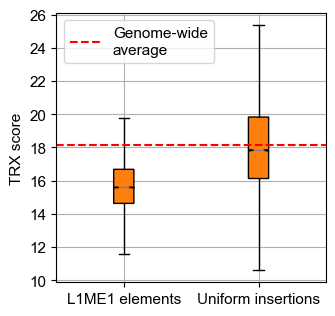

In [29]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
TRX_all=[TRX_all_pos_1_all_chr,TRX_all_rd_pos_1_all_chr]
#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(TRX_all,positions=x_pos,showfliers=False,notch=True,bootstrap=1000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")
#plt.text(0.5, avg_TRX_all_di_nu+0.1, 'Genome-wide average', color='r',fontname = "Arial", fontsize=12, ha='center')

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["L1ME1 elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("TRX score",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/TRX_L1ME2_control_1.pdf",format="pdf",bbox_inches="tight")


In [30]:
print("Mean, Std. TE", np.mean(TRX_all_pos_1_all_chr), np.std(TRX_all_pos_1_all_chr))
print("Mean, Std. Control", np.mean(TRX_all_rd_pos_1_all_chr), np.std(TRX_all_rd_pos_1_all_chr))

Mean, Std. TE 15.721932502744835 1.8352358370625577
Mean, Std. Control 18.1331728499502 2.8995274962613182


In [31]:
#stat sign. for clusters 2-4 elem.
t_s_1, p_value_1=scipy.stats.mannwhitneyu(x=TRX_all_pos_1_all_chr,y=TRX_all_rd_pos_1_all_chr,alternative="two-sided")
print("pvalue:",p_value_1)

pvalue: 0.0


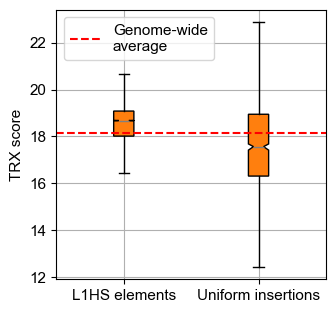

In [32]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
TRX_all=[TRX_all_pos_2_all_chr,TRX_all_rd_pos_2_all_chr]
#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(TRX_all,positions=x_pos,showfliers=False,notch=True,bootstrap=1000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["L1HS elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("TRX score",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/TRX_L1MB3_control_1.pdf",format="pdf",bbox_inches="tight")


In [33]:
print("Mean, Std. TE", np.mean(TRX_all_pos_2_all_chr), np.std(TRX_all_pos_2_all_chr))
print("Mean, Std. Control", np.mean(TRX_all_rd_pos_2_all_chr), np.std(TRX_all_rd_pos_2_all_chr))

Mean, Std. TE 18.61125889216189 1.4545675050096707
Mean, Std. Control 17.759082002569386 2.305897732392357


In [34]:
#stat sign. for clusters 2-4 elem.
t_s_2, p_value_2=scipy.stats.mannwhitneyu(x=TRX_all_pos_2_all_chr,y=TRX_all_rd_pos_2_all_chr,alternative="two-sided")
print("pvalue:",p_value_2)

pvalue: 3.9570635989015275e-58


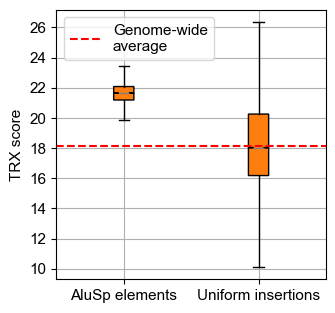

In [35]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
TRX_all=[TRX_all_pos_3_all_chr,TRX_all_rd_pos_3_all_chr]
#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(TRX_all,positions=x_pos,showfliers=False,notch=True,bootstrap=1000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["AluSp elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("TRX score",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/TRX_AluSq2_control_1.pdf",format="pdf",bbox_inches="tight")


In [36]:
print("Mean, Std. TE", np.mean(TRX_all_pos_3_all_chr), np.std(TRX_all_pos_3_all_chr))
print("Mean, Std. Control", np.mean(TRX_all_rd_pos_3_all_chr), np.std(TRX_all_rd_pos_3_all_chr))

Mean, Std. TE 21.60637365894226 0.832170961169406
Mean, Std. Control 18.32726798163932 2.944041973612709


In [37]:
#stat sign. for clusters 2-4 elem.
t_s_3, p_value_3=scipy.stats.mannwhitneyu(x=TRX_all_pos_3_all_chr,y=TRX_all_rd_pos_3_all_chr,alternative="two-sided")
print("pvalue:",p_value_3)

pvalue: 0.0


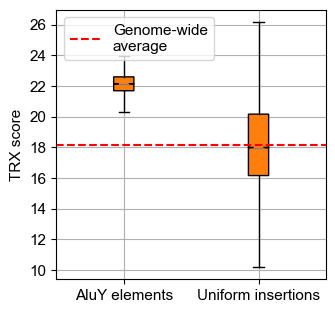

In [38]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
TRX_all=[TRX_all_pos_4_all_chr,TRX_all_rd_pos_4_all_chr]
#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(TRX_all,positions=x_pos,showfliers=False,notch=True,bootstrap=1000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["AluY elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("TRX score",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/TRX_AluJr_control_1.pdf",format="pdf",bbox_inches="tight")


In [39]:
print("Mean, Std. TE", np.mean(TRX_all_pos_4_all_chr), np.std(TRX_all_pos_4_all_chr))
print("Mean, Std. Control", np.mean(TRX_all_rd_pos_4_all_chr), np.std(TRX_all_rd_pos_4_all_chr))

Mean, Std. TE 22.085040436060556 1.0317788209179632
Mean, Std. Control 18.283198013570665 2.9271012189761243


In [40]:
#stat sign. for clusters 2-4 elem.
t_s_4, p_value_4=scipy.stats.mannwhitneyu(x=TRX_all_pos_4_all_chr,y=TRX_all_rd_pos_4_all_chr,alternative="two-sided")
print("pvalue:",p_value_4)

pvalue: 0.0


In [41]:
TRX_all_pos_4_all_chr

array([23.30555556, 22.38926174, 23.37873754, ..., 21.17316017,
       21.4775641 , 22.84590164])

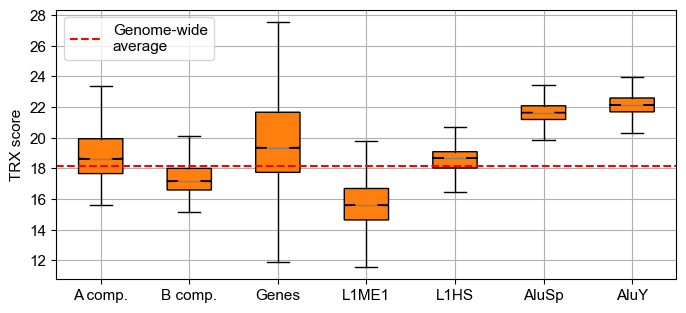

In [42]:
fig=plt.figure(figsize=(8,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1,2,3,4,5,6])
#TRX_all=[TRX_all_pos_1_all_chr,TRX_all_pos_2_all_chr,TRX_all_pos_3_all_chr,TRX_all_pos_4_all_chr,TRX_AB_HeLa_fA,TRX_AB_HeLa_fB,TRX_genes_hg19]
TRX_all=[TRX_AB_HeLa_fA,TRX_AB_HeLa_fB,TRX_genes_hg19,TRX_all_pos_1_all_chr,TRX_all_pos_2_all_chr,TRX_all_pos_3_all_chr,TRX_all_pos_4_all_chr]

#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

bp1=ax1.boxplot(TRX_all,positions=x_pos,showfliers=False,notch=True,bootstrap=1000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")
#plt.text(0.5, avg_TRX_all_di_nu+0.1, 'Genome-wide average', color='r',fontname = "Arial", fontsize=12, ha='center')

plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["A comp.","B comp.","Genes","L1ME1","L1HS","AluSp","AluY"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("TRX score",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
#ax1.set_aspect(1./ax1.get_data_ratio())

#plt.savefig("Transposon_analysis_1/figures/bp_TRX_diff_elem_2.pdf",format="pdf",bbox_inches="tight")


# TRX score with age of transposon

In [43]:
#https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.0030137
#Tranposons ordered by age according to level of defragmentation (not sequence based)
#analysis uses names from hg18, here, only TE which can be matched by name to the hg19 data set are used, meaning that some (~45 out of 405) are excluded
TE_age=pd.read_csv("Transposon_analysis_1/Transposon_405_age_Giordano_2007.csv", sep=';', header=1)


In [44]:
TE_age

Position       Name  Fragments  Units  Gets Interrupted  Interrupts  \
0           1      MARNA       3279   2968                76           5   
1           2  Charlie11         89     62                23           0   
2           3      L1MEd      16274   8460               308          39   
3           4         L3      46012  37637               282          79   
4           5     ERVL-E       9573   4983               265          54   
..        ...        ...        ...    ...               ...         ...   
400       401      L1PA2       4786   4684                 3         229   
401       402       LTR7       2353   2341                 2         194   
402       403     AluYg6        586    585                 0         123   
403       404     AluYa5       3939   3937                 0         257   
404       405     AluYb8       2623   2619                 0         226   

     Interactions      Ratio  % Connected  Div 0%  ...  L1MB  L1PB  L1MC/D  \
0              81  15.200000    20.000000     5.0  ...   NaN   NaN     NaN   
1              23   0.000000     5.679012    16.2  ...   NaN   NaN     NaN   
2             347   7.897436    85.679012     3.6  ...   NaN   NaN     NaN   
3             361   3.569620    89.135802     0.0  ...   NaN   NaN     NaN   
4             319   4.907407    78.765432    10.8  ...   NaN   NaN     NaN   
..            ...        ...          ...     ...  ...   ...   ...     ...   
400           232   0.013100    57.283951     0.0  ...   NaN   NaN     NaN   
401           196   0.010309    48.395062     2.2  ...   NaN   NaN     NaN   
402           123   0.000000    30.370370     0.0  ...   NaN   NaN     NaN   
403           257   0.000000    63.456790     0.0  ...   NaN   NaN     NaN   
404           226   0.000000    55.802469     0.0  ...   NaN   NaN     NaN   

      L1PA  L1MA  AluJ    Charlie  Tigger  AluS    AluY  
0      NaN   NaN   NaN        NaN     NaN   NaN     NaN  
1      NaN   NaN   NaN  Charlie11     NaN   NaN     NaN  
2      NaN   NaN   NaN        NaN     NaN   NaN     NaN  
3      NaN   NaN   NaN        NaN     NaN   NaN     NaN  
4      NaN   NaN   NaN        NaN     NaN   NaN     NaN  
..     ...   ...   ...        ...     ...   ...     ...  
400  L1PA2   NaN   NaN        NaN     NaN   NaN     NaN  
401    NaN   NaN   NaN        NaN     NaN   NaN     NaN  
402    NaN   NaN   NaN        NaN     NaN   NaN  AluYg6  
403    NaN   NaN   NaN        NaN     NaN   NaN  AluYa5  
404    NaN   NaN   NaN        NaN     NaN   NaN  AluYb8  

[405 rows x 36 columns]

## Functions

In [45]:
#Get mean TRX scores for all transposon families in TE_age (only inlcude chromosomes in chr_list). Elements are selceted from TE_age df, all occurences of the familiy are selected from rmd, seqeunce is selected from refernce_genome_file 
def TRX_sorted_by_age_of_TE_1(TE_age,TE_age_name, rmd,rmd_repName, rmd_repClass, rmd_repFamily, rmd_genoName, rmd_genoStart, rmd_genoEnd,chr_list, refernce_genome_file):
    TE_TRX_by_age=[]

    #iterate through TEs ordered by age
    for index, row in TE_age.iterrows():
        age_index=index
        TE_age_name_sel=row[TE_age_name]

        #get position df for selected TE
        filtered_rmd=rmd[rmd[rmd_repName]==TE_age_name_sel]
        #only use chromosomes in list
        filtered_rmd=filtered_rmd[filtered_rmd[rmd_genoName].isin(chr_list)]
        #print(filtered_rmd[rmd_genoName].iloc[0])
        if (len(filtered_rmd)>0):
            TRX_filtered_rmd=calculate_TRX_for_df(df=filtered_rmd, reference_genome=refernce_genome_file,chr_name=rmd_genoName,start_name=rmd_genoStart, end_name=rmd_genoEnd)["TRX_score"].values
            
            mean_TRX_filtered_rmd=np.mean(TRX_filtered_rmd)

            dict_TE_TRX_by_age={"repName":TE_age_name_sel,
            "repClass":filtered_rmd[rmd_repClass].iloc[0],
            "repFamily":filtered_rmd[rmd_repFamily].iloc[0],
            "Age index":age_index,
            "Mean TRX":mean_TRX_filtered_rmd
            }
            TE_TRX_by_age.append(dict_TE_TRX_by_age)
            print(index+1,"/",len(TE_age))
            #print(TE_TRX_by_age)
        else:
            print(index+1,"/",len(TE_age))
    df_TE_TRX_by_age=pd.DataFrame(TE_TRX_by_age)
    
    return df_TE_TRX_by_age

## Averaged TRX for all transposon families that could be sorted by age

In [116]:
%%time
TRX_sorted_by_age=TRX_sorted_by_age_of_TE_1(TE_age=TE_age,TE_age_name="Name", rmd=rmd,rmd_repName="repName", rmd_repClass="repClass", rmd_repFamily="repFamily", rmd_genoName="genoName", rmd_genoStart="genoStart", rmd_genoEnd="genoEnd",chr_list=chr_list, refernce_genome_file="Transposon_analysis_1/hg19.fa")

1 / 405
2 / 405
3 / 405
4 / 405
5 / 405
6 / 405
7 / 405
8 / 405
9 / 405
10 / 405
11 / 405
12 / 405
13 / 405
14 / 405
15 / 405
16 / 405
17 / 405
18 / 405
19 / 405
20 / 405
21 / 405
22 / 405
23 / 405
24 / 405
25 / 405
26 / 405
27 / 405
28 / 405
29 / 405
30 / 405
31 / 405
32 / 405
33 / 405
34 / 405
35 / 405
36 / 405
37 / 405
38 / 405
39 / 405
40 / 405
41 / 405
42 / 405
43 / 405
44 / 405
45 / 405
46 / 405
47 / 405
48 / 405
49 / 405
50 / 405
51 / 405
52 / 405
53 / 405
54 / 405
55 / 405
56 / 405
57 / 405
58 / 405
59 / 405
60 / 405
61 / 405
62 / 405
63 / 405
64 / 405
65 / 405
66 / 405
67 / 405
68 / 405
69 / 405
70 / 405
71 / 405
72 / 405
73 / 405
74 / 405
75 / 405
76 / 405
77 / 405
78 / 405
79 / 405
80 / 405
81 / 405
82 / 405
83 / 405
84 / 405
85 / 405
86 / 405
87 / 405
88 / 405
89 / 405
90 / 405
91 / 405
92 / 405
93 / 405
94 / 405
95 / 405
96 / 405
97 / 405
98 / 405
99 / 405
100 / 405
101 / 405
102 / 405
103 / 405
104 / 405
105 / 405
106 / 405
107 / 405
108 / 405
109 / 405
110 / 405
111 / 40

In [46]:
#Save and load TRX of transposons sorted by age

#TRX_sorted_by_age.to_csv('Transposon_analysis_1/save_elements/TRX_sorted_by_age_V1.csv', index=False)

TRX_sorted_by_age = pd.read_csv('Transposon_analysis_1/save_elements/TRX_sorted_by_age_V1.csv')

In [47]:
TRX_sorted_by_age #[TRX_sorted_by_age["repName"]=="AluSp"]


repName repClass      repFamily  Age index   Mean TRX
0        MARNA      DNA  TcMar-Mariner          0  16.522096
1    Charlie11      DNA    hAT-Charlie          1  15.866088
2        L1MEd     LINE             L1          2  15.679691
3           L3     LINE            CR1          3  17.600551
4       L1ME4a     LINE             L1          5  14.715010
..         ...      ...            ...        ...        ...
355      L1PA2     LINE             L1        400  18.232637
356       LTR7      LTR           ERV1        401  21.217075
357     AluYg6     SINE            Alu        402  21.838312
358     AluYa5     SINE            Alu        403  22.650782
359     AluYb8     SINE            Alu        404  22.780260

[360 rows x 5 columns]

In [48]:
#Names of sub-families
unique_v3 = [TRX_sorted_by_age[col_name].unique() for col_name in TRX_sorted_by_age.columns]

for i in unique_v3[2]:
    print(i)

TcMar-Mariner
hAT-Charlie
L1
CR1
RTE
TcMar-Tigger
L2
MIR
TcMar-Tc2
hAT-Tip100
ERVL-MaLR
hAT-Blackjack
ERVL
ERV1
hAT
MuDR
Alu
DNA
PiggyBac
ERVK


Pearson correlation coefficient all data: 0.5090104512521906
P-value: 4.003400335357988e-25
R^2 model 1 0.5890125636669391
P-values intercept, slope model 1 [3.48058334e-96 4.54568891e-19]
Pearson correlation coefficient dataset 1: 0.7674715393204751
P-value: 4.545688912027659e-19
R^2 model 2 0.6078246291974749
P-values intercept, slope model 2 [1.00296229e-10 3.69334102e-04]
Pearson correlation coefficient dataset 2: 0.7796310853201502
P-value: 0.00036933410200236226
Numnber of analyzed transposons: 360


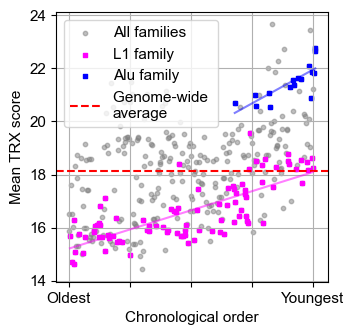

In [49]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)

age_index_ls=TRX_sorted_by_age["Age index"].tolist()
TRX_by_age_ls=TRX_sorted_by_age["Mean TRX"].tolist()

# Calculate Pearson correlation
P_corr0, P_p_value0= scipy.stats.pearsonr(age_index_ls, TRX_by_age_ls)

print(f'Pearson correlation coefficient all data: {P_corr0}')
print(f'P-value: {P_p_value0}')

###############
age_index_sel1_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="L1"]["Age index"].tolist()
TRX_by_age_sel1_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="L1"]["Mean TRX"].tolist()

###############
age_index_sel2_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="Alu"]["Age index"].tolist()
TRX_by_age_sel2_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="Alu"]["Mean TRX"].tolist()

###############
#age_index_sel3_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="ERV1"]["Age index"].tolist()
#TRX_by_age_sel3_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="ERV1"]["Mean TRX"].tolist()



##############
#ax1.errorbar(age_index_ls,TRX_by_age_ls,fmt=".",label="All families",color="grey")
#ax1.errorbar(age_index_sel1_ls,TRX_by_age_sel1_ls,fmt=".",label="L1 family",color="magenta")
#ax1.errorbar(age_index_sel2_ls,TRX_by_age_sel2_ls,fmt=".",label="Alu family",color="blue")
#ax1.errorbar(age_index_sel3_ls,TRX_by_age_sel3_ls,fmt=".",label="ERV1 elements",color="orange")
ax1.scatter(age_index_ls,TRX_by_age_ls,marker="o",label="All families",color="grey",s=10,alpha=0.5)
ax1.scatter(age_index_sel1_ls,TRX_by_age_sel1_ls,marker="s",label="L1 family",color="magenta",s=10)
ax1.scatter(age_index_sel2_ls,TRX_by_age_sel2_ls,marker="s",label="Alu family",color="blue",s=10)
#ax1.scatter(age_index_sel3_ls,TRX_by_age_sel3_ls,marker="s",label="ERV1 elements",color="orange",s=10)


ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")


################
model_lin_1 = LinearRegression()
model_lin_1.fit(np.array(age_index_sel1_ls).reshape(-1, 1),TRX_by_age_sel1_ls)
pred_TRX_by_age_sel1_ls=model_lin_1.predict(np.array(age_index_sel1_ls).reshape(-1, 1))
r2_model_lin_1 = r2_score(TRX_by_age_sel1_ls, pred_TRX_by_age_sel1_ls)
print("R^2 model 1",r2_model_lin_1)
ax1.errorbar(age_index_sel1_ls,pred_TRX_by_age_sel1_ls,color="magenta",alpha=0.5)

x_1_ols_const=sm.add_constant(age_index_sel1_ls)
y_1_ols=TRX_by_age_sel1_ls
model_sm1 = sm.OLS(y_1_ols, x_1_ols_const).fit()

# Get the p-values
p_values1 = model_sm1.pvalues
print("P-values intercept, slope model 1",p_values1)

# Calculate Pearson correlation
P_corr1, P_p_value1 = scipy.stats.pearsonr(age_index_sel1_ls, TRX_by_age_sel1_ls)

print(f'Pearson correlation coefficient dataset 1: {P_corr1}')
print(f'P-value: {P_p_value1}')
################
model_lin_2 = LinearRegression()
model_lin_2.fit(np.array(age_index_sel2_ls).reshape(-1, 1),TRX_by_age_sel2_ls)
pred_TRX_by_age_sel2_ls=model_lin_2.predict(np.array(age_index_sel2_ls).reshape(-1, 1))
r2_model_lin_2 = r2_score(TRX_by_age_sel2_ls, pred_TRX_by_age_sel2_ls)
print("R^2 model 2",r2_model_lin_2)
ax1.errorbar(age_index_sel2_ls,pred_TRX_by_age_sel2_ls,color="blue",alpha=0.5)

x_2_ols_const=sm.add_constant(age_index_sel2_ls)
y_2_ols=TRX_by_age_sel2_ls
model_sm2 = sm.OLS(y_2_ols, x_2_ols_const).fit()

# Get the p-values
p_values2 = model_sm2.pvalues
print("P-values intercept, slope model 2",p_values2)

# Calculate Pearson correlation
P_corr2, P_p_value2 = scipy.stats.pearsonr(age_index_sel2_ls, TRX_by_age_sel2_ls)

print(f'Pearson correlation coefficient dataset 2: {P_corr2}')
print(f'P-value: {P_p_value2}')


plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 

plt.xticks([0,100,200,300,400],["Oldest","","","","Youngest"],fontname = "Arial",fontsize=11) 

plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
plt.xlabel("Chronological order",fontname = "Arial",fontsize=11)
plt.grid()

#plt.savefig("Transposon_analysis_1/figures/Mean_TRX_vs_TE_age_3.pdf",format="pdf",bbox_inches="tight")


print("Numnber of analyzed transposons:",len(TRX_by_age_ls))

In [50]:
len(unique_v3[2])

20

/tmp/ipykernel_100/620637104.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_colors)


Numnber of analyzed transposons: 360


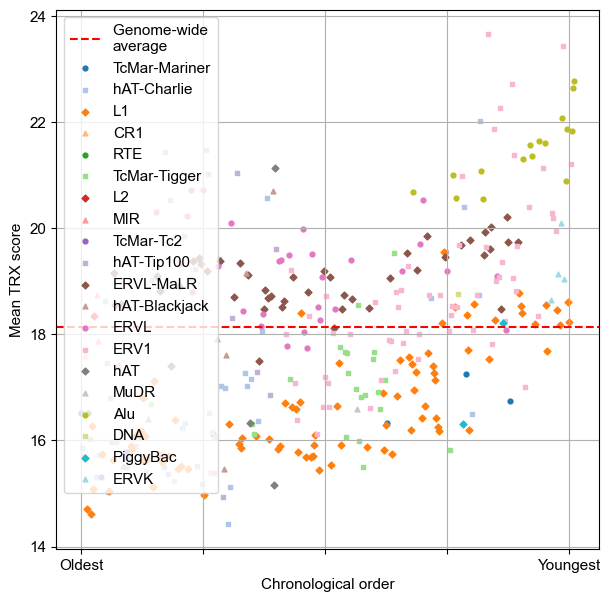

In [51]:
fig=plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")

def generate_colors(num_colors):
    colors = plt.cm.get_cmap('tab20', num_colors)
    return [colors(i) for i in range(num_colors)]
colors_1 = generate_colors(len(unique_v3[2]))
markers_1 = ['o', 's', 'D', '^']
for i in range(len(unique_v3[2])):
    fam_name=unique_v3[2][i]
    marker=markers_1[i%len(markers_1)]
    ###############
    age_index_sel1_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]==fam_name]["Age index"].tolist()
    TRX_by_age_sel1_ls=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]==fam_name]["Mean TRX"].tolist()
    

    
    ##############
    ax1.scatter(age_index_sel1_ls,TRX_by_age_sel1_ls,marker=marker,label=fam_name,color=colors_1[i],s=12)
    #ax1.errorbar(age_index_sel3_ls,TRX_by_age_sel3_ls,fmt=".",label="ERV1 elements",color="orange")




plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 
plt.xticks([0,100,200,300,400],["Oldest","","","","Youngest"],fontname = "Arial",fontsize=11) 


plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
plt.xlabel("Chronological order",fontname = "Arial",fontsize=11)
plt.grid()

print("Numnber of analyzed transposons:",len(TRX_by_age_ls))

#plt.savefig("Transposon_analysis_1/figures/Mean_TRX_vs_TE_age_all_fam_1.pdf",format="pdf",bbox_inches="tight")


# TRX score against overlap with open chromatin

## Get cluster coords for TEs, get overlap % of clusters with open chr

## Read in data on open chromatin


## Chromatin accessibility using ENCODE/openChrom data
### https://www.encodeproject.org/annotations/ENCSR236YNV/



### http://genome.ucsc.edu/cgi-bin/hgTrackUi?db=hg19&g=wgEncodeOpenChromSynth
validated, OC Code = 1:

        Black: Regions identified as peaks by both the DNaseI HS assay and FAIRE assay. Peaks for DNaseI HS have DNase peak calling p-values < 0.05 (-log10(p-value) > 1.3) and peaks for FAIRE have FAIRE peak calling p-values < 0.1 (-log10(p-value) > 1.0). 


Open Chromatin, OC Code = 2 or 3:

        Blue (high significance): Regions not identified as peaks in both DNaseI HS and FAIRE, but for which the combination of peak calling p-values from these assays using Fisher's combined probability test results in a p-value < 0.01 (-log10(p-value) > 2).


DNase, OC Code = 2:

        Green (low significance): Regions identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)) and not identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


FAIRE, OC Code = 3:

        Dark Red (low significance): Regions identified by FAIRE as peaks (FAIRE peak calling p-value < 0.1 (-log10(p-value) > 1.0)) and not identified by DNaseI HS as peaks (DNase peak calling p-value < 0.05 (-log10(p-value) > 1.3)), and with a Fisher's combined DNaseI HS and FAIRE p-value >= 0.01 (-log10(p-value) <= 2).
        Blue (high significance): see Open Chromatin above.


ChIP-seq, OC Code = 4:

        Pink: Regions identified by ChIP-seq as peaks (at least one of the peak calling p-values for the three ChIP experiments are < 0.05 (-log10(p-value) > 1.3)) indicating binding sites for one or more of RNA Pol II, CTCF, and c-Myc described here and not identified by DNaseI HS or FAIRE as peaks. Peaks for ChIP-seq have p-values < 0.05 (-log10(p-value) > 1.3). For RNA Pol II, only sites that overlap annotated transcription start sites by the UCSC Genes track are considered. 

All signal values, -log10(p-values), and the OC Code are displayed on the detail page for each element and are available in the corresponding bed file. 

In [52]:
#read in open chromatin dataset
Chr_acc_peaks=pd.read_csv("Transposon_analysis_1/DNAse_I_ENCFF001UZS/HelaS3_OC.bed",sep="\t",header = None)

Chr_acc_peaks.columns = ["chrom","chromStart","chromEnd","name","score","strand","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20"]

In [53]:
Chr_acc_peaks_sel1_p1=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("Valid")]
Chr_acc_peaks_sel1_p2=Chr_acc_peaks[Chr_acc_peaks["name"].str.startswith("OpenChrom")]
Chr_acc_peaks_sel1=pd.concat([Chr_acc_peaks_sel1_p1,Chr_acc_peaks_sel1_p2])

## Functions

In [54]:
#function to select repetitive elements
def sel_rep_element_on_chr(rmd_1,chr_list,elements_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[0]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx.iloc[:,3].str.startswith(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list

def sel_rep_element_on_chr_2(rmd_1,chr_list,elements_name,chr_col_name,element_col_name):
    rmd_list=[]
    for i in range(len(chr_list)):
        rmd_chrx=rmd_1[rmd_1[chr_col_name]==chr_list[i]]
        if elements_name!=None:
            rmd_chrx_sel=rmd_chrx[rmd_chrx[element_col_name].str.fullmatch(elements_name)]
            rmd_list.append(rmd_chrx_sel)
        if elements_name==None:
            rmd_list.append(rmd_chrx)
    return rmd_list


##################
##################

#get positions and length of elements
def positions_elements_2_b(rmd_input):
    #rmd_input: repeat masker file with positions from only one chr
    #get position middle of element on chr:
    pos=[]
    len_element=[]
    for i in range(len(rmd_input)):
        len_1=rmd_input[i:i+1]["genoEnd"].to_numpy()[0]-rmd_input[i:i+1]["genoStart"].to_numpy()[0]
        pos_1=rmd_input[i:i+1]["genoStart"].to_numpy()[0] + 0.5*len_1
        
        pos.append(pos_1)
        len_element.append(len_1)
    return np.asarray(pos), np.asarray(len_element)

#get positions and lengths of elements
def get_pos_dist_2_s(chr_list,rmd_list):
    #list of positions
    pos_x_list=[]
    #list of lengths
    len_x_list=[]
    #list of uniformly distributed positions
    pos_rd_x_list=[]

    #list of pairwise distances in each chromosome
    dist_x_list=[]
    #list of pairwise distances from uniformly distributed elements
    dist_rd_x_list=[]
    for i in range(len(chr_list)):
        #print(chr_list[i])
        positions_elements_x,lenghts_elements_x=positions_elements_2_b(rmd_list[i])
        pos_x_list.append(positions_elements_x)
        len_x_list.append(lenghts_elements_x)
 
    return pos_x_list,len_x_list


##################
##################

#DBSCAN algorithm
#! crashes for high number of points due to memory 
def DB_scan_1(eps,min_samples,input_):

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    #print(n_clusters_)

    #get particles per cluster 
    counter_labels=Counter(labels)
    

    counter_labels=dict(counter_labels)

    counter_numbers=[]

    for key, value in counter_labels.items():
        #en=counter_labels{i}
        if key !=-1:
            counter_numbers.append(value)
    counter_numbers=np.asarray(counter_numbers)
    
    #percentage of points in clusters:
    try: #if noise present
        perc_in_cluster=1-counter_labels[-1]/len(input_)
    except: #if no noise present, all points part of clusters
        perc_in_cluster=1

    #get mean particle number, get mean only if clusters detected, else append 0    
    if n_clusters_>0:
        mean_cluster_number=np.mean(counter_numbers)
    else:    
        mean_cluster_number=0

    return n_clusters_,mean_cluster_number,perc_in_cluster

#apply DBSCAN to dataset split by chromosomes
#get number of clusters, fraction of elements in clusters for transposons and random insertions
#based on DB_scan_appl_1 in clustering_analysis_1, but no analysis of control elements
def DB_scan_appl_1_s(eps_1,min_samples_1,chr_list,pos_x_list): 
    n_clusters_1=[]
    #n_clusters_rd_1=[]

    mean_cluster_number_1=[]
    #mean_cluster_number_rd_1=[]

    perc_in_cluster_1=[]
    #perc_in_cluster_rd_1=[]

    #eps_1=10000
    #min_samples_1=2

    for i in range(len(chr_list[:])):
        n_clusters_1_e,mean_cluster_number_1_e,perc_in_cluster_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_x_list[i].reshape(-1,1))

        n_clusters_1.append(n_clusters_1_e)
        perc_in_cluster_1.append(perc_in_cluster_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_1_e>0:
         #   mean_cluster_number_1.append(mean_cluster_number_1_e)
        #append even for zero average particle number
        mean_cluster_number_1.append(mean_cluster_number_1_e)


        ########################################

        #n_clusters_rd_1_e,mean_cluster_number_rd_1_e,perc_in_cluster_rd_1_e=DB_scan_1(eps=eps_1,min_samples=min_samples_1,input_=pos_rd_x_list[i].reshape(-1,1))

        #n_clusters_rd_1.append(n_clusters_rd_1_e)
        #perc_in_cluster_rd_1.append(perc_in_cluster_rd_1_e)

        #if no cluster detected, dont append zero average particle number in cluster
        #if mean_cluster_number_rd_1_e>0:
         #   mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)    
        #append even for zero average particle number
        #mean_cluster_number_rd_1.append(mean_cluster_number_rd_1_e)

    n_clusters_1=np.asarray(n_clusters_1)
    #n_clusters_rd_1=np.asarray(n_clusters_rd_1)

    mean_cluster_number_1=np.asarray(mean_cluster_number_1)
    #mean_cluster_number_rd_1=np.asarray(mean_cluster_number_rd_1)

    perc_in_cluster_1=np.asarray(perc_in_cluster_1)
    #perc_in_cluster_rd_1=np.asarray(perc_in_cluster_rd_1)


    #non zero entries
    mean_cluster_number_1_nz=mean_cluster_number_1[np.nonzero(mean_cluster_number_1)]
    #mean_cluster_number_rd_1_nz=mean_cluster_number_rd_1[np.nonzero(mean_cluster_number_rd_1)]
    
    return n_clusters_1, mean_cluster_number_1, mean_cluster_number_1_nz, perc_in_cluster_1



#apply DBSCAN to dataset split by chromosomes
#apply DB scan, get data points not in clusters (noise) and centres of data points with different ranges of points in them
#get extension of clusters from start of first element to end of last element
def DB_scan_appl_7b(dataset, point_sizes, eps, min_samples,points_in_clusters):
    
    
    ####
    ###
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(dataset)

    #Get labels and number of occurences (= number of points in cluster), including noise points with label = 0
    unique_labels2, counts2 = np.unique(labels, return_counts=True)
    unique_labels=[]
    counts=[]
    #print(unique_labels2,counts2)
    #filter out counts and label for noise points 
    for i in range(len(unique_labels2)):
        if unique_labels2[i]!=-1:
            unique_labels.append(unique_labels2[i])
            counts.append(counts2[i])
            
    #get centres of cluster masked by label (each cluster has unique label)
    #cluster_centers = [dataset[labels == label].mean(axis=0)[0] for label in unique_labels]
    #get sizes of clusters
    #get end points of all points in cluster (i.e. middle plus extension/2) and then get max value
    cluster_max=[ np.asarray([dataset[labels == label]+point_sizes[labels == label]/2])[0].max(axis=0)[0] for label in unique_labels]
    #print(cluster_max)
    #print(np.asarray([dataset[labels == label]+point_sizes[labels == label]/2 for label in unique_labels])[0] )
    #same for middle minus extension/2
    cluster_min=[ np.asarray([dataset[labels == label]-point_sizes[labels == label]/2])[0].min(axis=0)[0] for label in unique_labels]
        
    cluster_sizes = np.asarray(cluster_max)-np.asarray(cluster_min)
    
    cluster_centers= cluster_sizes/2 + np.asarray(cluster_min)
    
    #get subset of cluster centres wich have cluster number in specific range
    centres_clusters_by_range=[]
    sizes_clusters_by_range=[]
    for i in range(len(points_in_clusters)):
        
        centers = [center for center, count in zip(cluster_centers, counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        #print(centers)
        centres_clusters_by_range.append(centers)
        
        ####
        sizes = [ size for size, count in zip(cluster_sizes,counts) if points_in_clusters[i][0]<=count<points_in_clusters[i][1]]
        sizes_clusters_by_range.append(sizes)
    #get noise points
    outliers = dataset[labels == -1]
    outlier_sizes=point_sizes[labels == -1]

    return outliers, outlier_sizes,centres_clusters_by_range, sizes_clusters_by_range


#apply DB_scan_appl_7b to data partitioned by chromosomes
#based on DB_scan_appl_8 in clustering_analysis_1, but no analysis of control elements
def DB_scan_appl_8_s(eps,min_samples,chr_list,pos_x_list,len_x_list,points_in_clusters):
    centres_clusters_by_range_all_chr=[]
    sizes_clusters_by_range_all_chr=[]
    #centres_clusters_by_range_rd_all_chr=[]
    #sizes_clusters_by_range_rd_all_chr=[]
    
    noise_all_chr=[]
    noise_size_all_chr=[]
    #noise_all_chr_rd=[]
    #noise_size_chr_rd=[]
    for i in range(len(chr_list)):
        #both positions and random positions use same point lengths
        outliers,outlier_sizes, centres_clusters_by_range, sizes_clusters_by_range=DB_scan_appl_7b(dataset=pos_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)
        #outliers_rd,outlier_rd_sizes, centres_clusters_by_range_rd, sizes_clusters_by_range_rd=DB_scan_appl_7b(dataset=pos_rd_x_list[i].reshape(-1,1),point_sizes=len_x_list[i].reshape(-1,1), eps=eps, min_samples=min_samples,points_in_clusters=points_in_clusters)

        centres_clusters_by_range_all_chr.append(centres_clusters_by_range)
        sizes_clusters_by_range_all_chr.append(sizes_clusters_by_range)
        noise_all_chr.append(outliers)
        noise_size_all_chr.append(outlier_sizes)
        
        #centres_clusters_by_range_rd_all_chr.append(centres_clusters_by_range_rd)
        #sizes_clusters_by_range_rd_all_chr.append(sizes_clusters_by_range_rd)
        #noise_all_chr_rd.append(outliers_rd)
        #noise_size_chr_rd.append(outlier_rd_sizes)
        
    return centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr,noise_all_chr,noise_size_all_chr






#create df from chr_list, pos_list and len_list with id, chrom, start, stop, columns
def df_for_rd_positions_V1(chr_list, pos_rd_x_list, len_x_list):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)):
        #get chr
        chr_sel_list=[]
        rd_start_list=[]
        rd_stop_list=[]
        rd_id_list=[]
        count_1=0
    
        chr_sel=chr_list[i]
        for j in range(len(pos_rd_x_list[i])):
            #get pos
            start_sel=int(np.round(pos_rd_x_list[i][j]-len_x_list[i][j]/2 ,0))
            stop_sel=int(np.round(pos_rd_x_list[i][j]+len_x_list[i][j]/2 ,0))
            
            chr_sel_list.append(chr_sel)
            rd_start_list.append(start_sel)
            rd_stop_list.append(stop_sel)
            rd_id_list.append(count_1)
            count_1=count_1+1
            
        all_data={col_create[0]:rd_id_list,
             col_create[1]:chr_sel_list,
             col_create[2]:rd_start_list,
             col_create[3]:rd_stop_list}  
    
        df_rd=pd.DataFrame(all_data)
        df_rd_list.append(df_rd)
    return df_rd_list


#create df with cluster id, chrom, start and stop
#for chromosome and each detected cluster list for specified range of points (e.g. all cluster with 2-4 and all with >4 points) 
def df_for_cluster_positions_V1(chr_list,centres_clusters_by_range_all_chr,sizes_clusters_by_range_all_chr):
    #create df for random elements with same length on same chr as elements on chr 
    col_create=["REGION_ID","CHROM","START","STOP"]
    df_rd_list=[]

    for i in range(len(chr_list)): #chromosomes
        #get chr
 
        
    
        chr_sel=chr_list[i]
        df_rd_cluster_list=[]
        for j in range(len(centres_clusters_by_range_all_chr[i])): #cluster sizes
            count_1=0
            chr_sel_list=[]
            rd_start_list=[]
            rd_stop_list=[]
            rd_id_list=[]
            all_data={}
            for k in range(len(centres_clusters_by_range_all_chr[i][j])): #entries for each cluster size
                
                start_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]-sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))
                stop_sel=int(np.round(centres_clusters_by_range_all_chr[i][j][k]+sizes_clusters_by_range_all_chr[i][j][k]/2 ,0))

                chr_sel_list.append(chr_sel)
                rd_start_list.append(start_sel)
                rd_stop_list.append(stop_sel)
                rd_id_list.append(count_1)
                count_1=count_1+1

                all_data={col_create[0]:rd_id_list,
                     col_create[1]:chr_sel_list,
                     col_create[2]:rd_start_list,
                     col_create[3]:rd_stop_list}  
    
            df_rd=pd.DataFrame(all_data)
            df_rd_cluster_list.append(df_rd)
        df_rd_list.append(df_rd_cluster_list)
    return df_rd_list 
    
    
#https://stackoverflow.com/questions/16691524/calculating-the-overlap-distance-of-two-1d-line-segments
def calc_overlap(min1, max1, min2, max2):
    return max(0, min(max1, max2) - max(min1, min2))

#overlap for arrays
def calc_overlap_V2(max1, max2, min1, min2):
    result = np.maximum(0, np.minimum(max1, max2) - np.maximum(min1, min2))
    return result
#overlap for arrays, with distance separation if no overlap
def calc_overlap_V3(max1, max2, min1, min2):
    result = np.minimum(max1, max2) - np.maximum(min1, min2)
    return result

#check for each element in df1 if at least on element in df2 overlaps it (on the same chr)
def check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1, df2, chr_name_1,start_name_1,stop_name_1, chr_name_2,start_name_2,stop_name_2,min_dist=0):
    
    bool_overlap_entries=[] #if at least one element in df2 overlaps element i in df1
    
    for i in range(len(df1)):
        #get chr, start and stop of entry in df1
        chr_sel=df1.iloc[i][chr_name_1]
        start_sel=df1.iloc[i][start_name_1]
        stop_sel=df1.iloc[i][stop_name_1]
        
        #select sub dataframe on df2 with same chr
        df2_sel_chr=df2[df2[chr_name_2]==chr_sel]
        
        
        ###
        #get arrays of all start and stop points on chr
        start_sel_df2=df2_sel_chr.iloc[:][start_name_2].to_numpy()
        stop_sel_df2=df2_sel_chr.iloc[:][stop_name_2].to_numpy()
        
        overlap_array=calc_overlap_V3(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
        ###
        bool_overlap_e=0
        if any(x > min_dist for x in overlap_array):
            bool_overlap_e=1
        
        
        '''#check if element in df2 on same chr overlaps selected element in df1
        bool_overlap_e=0
        for j in range(len(df2_sel_chr)):
            start_sel_df2=df2_sel_chr.iloc[j][start_name_2]
            stop_sel_df2=df2_sel_chr.iloc[j][stop_name_2]
            #print(start_sel,stop_sel,"#",start_sel_df2,stop_sel_df2)
            
            overlap=calc_overlap(min1=start_sel,max1=stop_sel,min2=start_sel_df2,max2=stop_sel_df2)
            if overlap>0:
                bool_overlap_e=1
                break'''

        bool_overlap_entries.append(bool_overlap_e) 
        #print(i,"/",len(df1)-1)
    return bool_overlap_entries


In [55]:
#function that gets the overlap % of clusters with open chr for TEs named in list_TE_names
def overlap_perc_open_chr_1(list_TE_names,rmd,chr_list,eps,min_samples,points_in_clusters,Chr_acc_peaks_sel,max_sep_regions,min_num_points_cond):
    overlap_perc_open_chr={}
    for i in range(len(list_TE_names)):
        TE_sel=list_TE_names[i]
        print(TE_sel,i+1,"/",len(list_TE_names))
        try:
            #get data for selectec element spilt by chr
            rmd_list_sel= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=TE_sel,chr_col_name="genoName",element_col_name="repName")
    
            pos_sel_list,len_sel_list =get_pos_dist_2_s(chr_list=chr_list,rmd_list=rmd_list_sel)
    
    
            #apply DB scan
            #DBSCAN parameters
      
            centres_clusters_by_range_all_chr_sel,sizes_clusters_by_range_all_chr_sel,noise_all_chr_sel,noise_size_all_chr_sel=DB_scan_appl_8_s(eps=eps,min_samples=min_samples,chr_list=chr_list,pos_x_list=pos_sel_list,len_x_list=len_sel_list,points_in_clusters=points_in_clusters)
            
    
            #create a data frame for cluster positions split by chr and by number of points in cluster
            df_cluster_pos_sel=df_for_cluster_positions_V1(chr_list=chr_list,centres_clusters_by_range_all_chr=centres_clusters_by_range_all_chr_sel,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_all_chr_sel)
            #print(df_cluster_pos_sel)
            #overlap of clusters with open chromatin
            mean_overlap_clusters=[]
            for i in range(len(chr_list)):
                mean_overlap_clusters_e=[]
                for j in range(len(df_cluster_pos_sel[i])):
                    overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_sel[i][j], df2=Chr_acc_peaks_sel, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
                    mean_overlap_clusters_e.append(overlap_clusters_open_chr_e)
                mean_overlap_clusters.append(mean_overlap_clusters_e)
    
            mean_overlap_cluster_range_all_mean=[]
            for i in range(len(mean_overlap_clusters)):
                concat_overlap=np.concatenate((mean_overlap_clusters[i][0],mean_overlap_clusters[i][1]))
                if len(concat_overlap)>min_num_points_cond:
                    mean_overlap_cluster_range_all_mean.append(np.mean(concat_overlap))
    
                    
            overlap_perc_open_chr[TE_sel]=np.mean(mean_overlap_cluster_range_all_mean)
        except:
            overlap_perc_open_chr[TE_sel]=None
            print("Error with",TE_sel)
            
    return overlap_perc_open_chr

#parallel execution (not always faster)
#function that gets the overlap % of clusters with open chr for TEs named in list_TE_names
def overlap_perc_open_chr_1_sel(TE_sel,rmd,chr_list,eps,min_samples,points_in_clusters,Chr_acc_peaks_sel,max_sep_regions,min_num_points_cond):
    try:
        print(TE_sel)
        #get data for selectec element spilt by chr
        rmd_list_sel= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=TE_sel,chr_col_name="genoName",element_col_name="repName")
    
        pos_sel_list,len_sel_list =get_pos_dist_2_s(chr_list=chr_list,rmd_list=rmd_list_sel)
    
    
        #apply DB scan
        #DBSCAN parameters
    
        centres_clusters_by_range_all_chr_sel,sizes_clusters_by_range_all_chr_sel,noise_all_chr_sel,noise_size_all_chr_sel=DB_scan_appl_8_s(eps=eps,min_samples=min_samples,chr_list=chr_list,pos_x_list=pos_sel_list,len_x_list=len_sel_list,points_in_clusters=points_in_clusters)
        
    
        #create a data frame for cluster positions split by chr and by number of points in cluster
        df_cluster_pos_sel=df_for_cluster_positions_V1(chr_list=chr_list,centres_clusters_by_range_all_chr=centres_clusters_by_range_all_chr_sel,sizes_clusters_by_range_all_chr=sizes_clusters_by_range_all_chr_sel)
        #print(df_cluster_pos_sel)
        #overlap of clusters with open chromatin
        mean_overlap_clusters=[]
        for i in range(len(chr_list)):
            mean_overlap_clusters_e=[]
            for j in range(len(df_cluster_pos_sel[i])):
                overlap_clusters_open_chr_e=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=df_cluster_pos_sel[i][j], df2=Chr_acc_peaks_sel, chr_name_1="CHROM",start_name_1="START",stop_name_1="STOP", chr_name_2="chrom",start_name_2="chromStart",stop_name_2="chromEnd",min_dist=max_sep_regions)
                mean_overlap_clusters_e.append(overlap_clusters_open_chr_e)
            mean_overlap_clusters.append(mean_overlap_clusters_e)
    
        mean_overlap_cluster_range_all_mean=[]
        for i in range(len(mean_overlap_clusters)):
            concat_overlap=np.concatenate((mean_overlap_clusters[i][0],mean_overlap_clusters[i][1]))
            if len(concat_overlap)>min_num_points_cond:
                mean_overlap_cluster_range_all_mean.append(np.mean(concat_overlap))
    
                
        mean_overlap_cluster_range_all_mean_sel=np.mean(mean_overlap_cluster_range_all_mean)
        
    except:
        print("Error with",TE_sel)
        mean_overlap_cluster_range_all_mean_sel=None
    
    return TE_sel, mean_overlap_cluster_range_all_mean_sel
    
def parallel_overlap_perc_open_chr_1(num_workers,list_TE_names,rmd,chr_list,eps,min_samples,points_in_clusters,Chr_acc_peaks_sel,max_sep_regions,min_num_points_cond):
    result_dict = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor: #ProcessPoolExecutor
        futures = {executor.submit(overlap_perc_open_chr_1_sel, TE_sel,rmd,chr_list,eps,min_samples,points_in_clusters,Chr_acc_peaks_sel,max_sep_regions,min_num_points_cond): TE_sel for TE_sel in list_TE_names}
        for future in concurrent.futures.as_completed(futures):
            name, value = future.result()
            result_dict[name] = value
    return result_dict

#################
#################

#function that gets the overlap % of clusters with open chr for TEs named in list_TE_names
def fraction_elem_in_clusters_1(list_TE_names,rmd,chr_list,eps,min_samples):
    fraction_elem_in_clusters={}
    for i in range(len(list_TE_names)):
        TE_sel=list_TE_names[i]
        try:
            print(TE_sel)
            #get data for selectec element spilt by chr
            rmd_list_sel= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=TE_sel,chr_col_name="genoName",element_col_name="repName")
            
            pos_sel_list,len_sel_list =get_pos_dist_2_s(chr_list=chr_list,rmd_list=rmd_list_sel)
        
            #apply DB scan
            #DBSCAN parameters
            n_clusters_1, mean_cluster_number_1, mean_cluster_number_1_nz, perc_in_cluster_1=DB_scan_appl_1_s(eps_1=eps,min_samples_1=min_samples,chr_list=chr_list,pos_x_list=pos_sel_list)
            
            mean_fraction_elem_in_clusters_sel=np.mean(perc_in_cluster_1)
            
        except:
            print("Error with",TE_sel)
            mean_fraction_elem_in_clusters_sel=None
            
        fraction_elem_in_clusters[TE_sel]=mean_fraction_elem_in_clusters_sel
    return fraction_elem_in_clusters

    
#parallel (not always faster)
#function that gets the overlap % of clusters with open chr for TEs named in list_TE_names
def fraction_elem_in_clusters_sel_1(TE_sel,rmd,chr_list,eps,min_samples):
    try:
        print(TE_sel)
        #get data for selectec element spilt by chr
        rmd_list_sel= sel_rep_element_on_chr_2(rmd_1=rmd,chr_list=chr_list,elements_name=TE_sel,chr_col_name="genoName",element_col_name="repName")
    
        pos_sel_list,len_sel_list =get_pos_dist_2_s(chr_list=chr_list,rmd_list=rmd_list_sel)
    
    
        #apply DB scan
        #DBSCAN parameters
        n_clusters_1, mean_cluster_number_1, mean_cluster_number_1_nz, perc_in_cluster_1=DB_scan_appl_1_s(eps_1=eps,min_samples_1=min_samples,chr_list=chr_list,pos_x_list=pos_sel_list)
        mean_fraction_elem_in_clusters_sel=np.mean(perc_in_cluster_1)
    except:
        print("Error with",TE_sel)
        mean_fraction_elem_in_clusters_sel=None
    
    return TE_sel, mean_fraction_elem_in_clusters_sel
    
def parallel_fraction_elem_in_clusters_sel_1(num_workers,list_TE_names,rmd,chr_list,eps,min_samples):
    result_dict = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor: #ProcessPoolExecutor
        futures = {executor.submit(fraction_elem_in_clusters_sel_1, TE_sel,rmd,chr_list,eps,min_samples): TE_sel for TE_sel in list_TE_names}
        for future in concurrent.futures.as_completed(futures):
            name, value = future.result()
            result_dict[name] = value
    return result_dict



In [ ]:
%%time
dict_overlap_perc_open_chr2=overlap_perc_open_chr_1(list_TE_names=list_TE_names_3,rmd=rmd,chr_list=chr_list,eps=1e4,min_samples=2,points_in_clusters=[[2,5],[5,10000000]],Chr_acc_peaks_sel=Chr_acc_peaks_sel1,max_sep_regions=0,min_num_points_cond=10)

In [16]:
TRX_sorted_by_age

repName repClass      repFamily  Age index   Mean TRX
0        MARNA      DNA  TcMar-Mariner          0  16.522096
1    Charlie11      DNA    hAT-Charlie          1  15.866088
2        L1MEd     LINE             L1          2  15.679691
3           L3     LINE            CR1          3  17.600551
4       L1ME4a     LINE             L1          5  14.715010
..         ...      ...            ...        ...        ...
355      L1PA2     LINE             L1        400  18.232637
356       LTR7      LTR           ERV1        401  21.217075
357     AluYg6     SINE            Alu        402  21.838312
358     AluYa5     SINE            Alu        403  22.650782
359     AluYb8     SINE            Alu        404  22.780260

[360 rows x 5 columns]

In [26]:
#list_TE_names_1=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="L1"]["repName"].tolist()

#list_TE_names_2=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="Alu"]["repName"].tolist()

#list_TE_names_3=list_TE_names_1+list_TE_names_2


list_TE_names_3=TRX_sorted_by_age[~TRX_sorted_by_age["repFamily"].isin(["Alu","L1"])]["repName"].tolist()


check_ref_list=rmd["repName"].tolist()
list_TE_names_3=[item for item in list_TE_names_3 if item in check_ref_list ]
print(len(list_TE_names_3))

252


In [20]:
%%time

dict_overlap_perc_open_chr=parallel_overlap_perc_open_chr_1(num_workers=5,list_TE_names=list_TE_names_3,rmd=rmd,chr_list=chr_list,eps=1e4,min_samples=2,points_in_clusters=[[2,5],[5,10000000]],Chr_acc_peaks_sel=Chr_acc_peaks_sel1,max_sep_regions=0,min_num_points_cond=10)

MARNA
Charlie11
L3
L4
Tigger8
Error with Charlie11
L2
Charlie7
MIR3
MIRb
MER113
Kanga2_a
MER102b
Charlie8
Charlie2b
Zaphod2
Charlie2a
MLT1K
MLT1L
Charlie9
MER20B
MIR
MLT1J
BLACKJACK
MER112
MER102a
Kanga1
Arthur1
Zaphod
Charlie6
Error with Charlie6
Charlie4
Error with Charlie4
MER63D
Charlie4a
MER46C
MER91B
LTR33
MLT1J2
MLT1I
MER31-int
Charlie1a
FordPrefect_a
MER97c


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER115
Error with MER97c
MLT1H-int
LTR37B
MLT1J1
LTR33A
Charlie10
MER117
Cheshire
LTR16C
MER5B
LTR16A1
LTR50
MLT1H
FordPrefect
Charlie1b
MER5A
MLT1G
MLT1H2
MER5C
LTR16A
MER91A
MLT1H1
MER91C
MER58D


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LTR37A
MER57A-int
MADE2
MER97a


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Charlie1


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER94
MLT2F
MER5A1
MLT1G1
MER119
MER97b
Error with MER97b
MER63C
MER3
MER63B
Charlie5
MER33
LTR16B
MER45R


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MLT1F1
MER45C
MLT1F
LTR41
MER106A


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER63A
MER58C
MLT1F2
MER96B
MER58B
Tigger6a
Tigger6b


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER45B
MER106B
MLT1F-int
LTR40a
MER58A
LTR40b
MLT1E3
MLT1E1A
MER20
MLT1E
ORSL
MLT1E1
MER81
MER53
MER96


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER45A
MER68
LTR52
MLT1E2
MLT1D
MER92B
MLT2C1
MER77
MER82
MER89
MLT1C
MER67D
MER67C
MER74A
MLT2D
MLT2C2
MLT1B
MER31B
MER74B
LTR49-int
MLT2B4
MLT2B1
MER21C
MER4B-int
MLT1A
MER34
MER31A
MER34B
MER34C_
MLT1A0
MER39
MLT1A0-int
MLT2B2
MER44C
MSTD-int
Error with MSTD-int
MLT1A1
MER44B
MER44A
Tigger7
MER44D
LTR48
MER21B
MSTD
MER2
Ricksha
Error with Ricksha
MER2B
Tigger3b
Tigger5
MER6C
Error with MER6C
Tigger1
MSTC
LTR54
MER6
MER6A
LTR48B
Tigger2
Tigger2b_Pri
MER65A
Tigger2a
HSMAR2
LTR49
MSTB2
PRIMA4-int
MER8
LTR23
LTR26
MER39B
LTR39
LTR47A
MER4D
MER49
MSTB1
MER72
MSTB-int
MER4C
MER4D1
MER21A
LTR32
MSTB
LTR8A
MER30B
LOR1a
MSTA-int
Charlie3


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Error with Charlie3
MLT2B3
MER4A
MER6B
LOR1b


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER41B
MER4B
MER107


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER50
MSTA
MER66B
MER75


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER1A
HSMAR1
THE1D-int
Charlie12
Error with Charlie12
MER4E1
LTR8
MER30
MER1B
THE1D
THE1C-int
MER50B
MER52A
THE1C
THE1B-int
MER41C
LTR1D
MER41A
MLT2A2
MER4A1
LTR1B
MLT-int
MER51A
Error with MLT-int
MER85


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


PABL_A
MLT2A1


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


THE1A-int
THE1B
MADE1
LTR1
LTR9
MER61A
Error with MER61A
MER51B
LTR9B
THE1A
LTR10C
LTR12_
LTR10F
LTR17
Error with LTR10F
MER11A


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LTR7B
LTR2


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LTR12
MER11C
LTR5_Hs
LTR12C


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


MER11B


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LTR7


/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aaron/miniconda3/envs/transposon_analysis_1/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CPU times: user 34min 20s, sys: 6min 12s, total: 40min 33s
Wall time: 38min 15s


In [56]:
#Save and load overlap of cluster with open chr

#with open ("Transposon_analysis_1/save_elements/dict_overlap_perc_open_chr_no_L1_Alu.pkl","wb") as f:
    #pickle.dump(dict_overlap_perc_open_chr,f)


with open("Transposon_analysis_1/save_elements/dict_overlap_perc_open_chr_L1_Alu.pkl", 'rb') as f:
    dict_overlap_perc_open_chr1 = pickle.load(f)

with open("Transposon_analysis_1/save_elements/dict_overlap_perc_open_chr_no_L1_Alu.pkl", 'rb') as f:
    dict_overlap_perc_open_chr2 = pickle.load(f)

    

In [57]:
dict_overlap_perc_open_chr={**dict_overlap_perc_open_chr1,**dict_overlap_perc_open_chr2}

In [58]:
# add mean percentage of overlap to dataframe
def add_dict_overlap_perc_open_chr(name):
    return dict_overlap_perc_open_chr.get(name, None)

TRX_sorted_by_age["Mean overlap open chr."]=TRX_sorted_by_age["repName"].apply(add_dict_overlap_perc_open_chr) 

TRX_sorted_by_age_filterd=TRX_sorted_by_age[TRX_sorted_by_age["Mean overlap open chr."].notnull()]
TRX_sorted_by_age_filterd

repName repClass      repFamily  Age index   Mean TRX  \
0     MARNA      DNA  TcMar-Mariner          0  16.522096   
2     L1MEd     LINE             L1          2  15.679691   
3        L3     LINE            CR1          3  17.600551   
4    L1ME4a     LINE             L1          5  14.715010   
5        L4     LINE            RTE          6  16.519028   
..      ...      ...            ...        ...        ...   
350  LTR12C      LTR           ERV1        395  23.431511   
352    FRAM     SINE            Alu        397  20.895647   
354    L1HS     LINE             L1        399  18.611259   
355   L1PA2     LINE             L1        400  18.232637   
356    LTR7      LTR           ERV1        401  21.217075   

     Mean overlap open chr.  
0                  0.026612  
2                  0.022691  
3                  0.083291  
4                  0.058775  
5                  0.041948  
..                      ...  
350                0.024471  
352                0.106512  
354                0.000000  
355                0.015294  
356                0.025989  

[321 rows x 6 columns]

In [59]:
elements_not_analyzed_overlap = TE_age[~TE_age['Name'].isin(TRX_sorted_by_age_filterd['repName'])]["Name"].tolist()
print(elements_not_analyzed_overlap)
print(len(elements_not_analyzed_overlap))

['Charlie11', 'ERVL-E', 'Charlie2', 'ERVL', 'LTR67', 'MER69B', 'MER91', 'Charlie6', 'HERV16', 'Charlie4', 'L1M', 'HERVL40', 'FordPrefect_a', 'ERVL-B4', 'MER97c', 'MIRm', 'HERVL', 'Tigger6', 'MER69A', 'MER91C', 'MADE2', 'MER97a', 'MER97b', 'MER45R', 'MER45', 'MER63', 'MER106A', 'MER58', 'Tigger6b', 'MER96', 'ERVL-B1', 'PMER1', 'MSTD-int', 'Tigger4(Zombi)', 'Tigger5a', 'Ricksha', 'Tigger3(Golem)', 'MER6C', 'MER46B', 'Tigger5b', 'MER7A', 'MER46A', 'MER7C', 'AluJ', 'Tigger5c', 'MER57A', 'MER30B', 'L1P5', 'L1P', 'MER7D', 'Charlie3', 'MER6B', 'MER107', 'MER75', 'Charlie12', 'MER4A1-int', 'MER57B', 'MLT-int', 'MER85', 'PABL_A', 'HERVL-A1', 'MER61A', 'AluJ/FLAM', 'AluSq/x', 'HERV9', 'LTR12_', 'AluSg1', 'HERVH', 'AluSg/x', 'LTR10F', 'AluJo/FLAM', 'AluS', 'Alu', 'AluJ/FRAM', 'MER9', 'MER11A', 'AluSp/q', 'MER11C', 'LTR5_Hs', 'MER11B', 'AluYd8', 'AluYg6', 'AluYa5', 'AluYb8']
84


In [60]:
#test why for some elements analyis failed: probably to few elements for DB scan clustering + criterion of at least 10 clusters for overlap calc.
#some are not found in the hg19 based dataset, presumably because some names were changed -> but total number of missing TEs low
for i in range(len(elements_not_analyzed_overlap)):
    name_elem=elements_not_analyzed_overlap[i]
    print(name_elem,len(rmd[rmd["repName"]==name_elem]))

Charlie11 111
ERVL-E 0
Charlie2 0
ERVL 0
LTR67 0
MER69B 0
MER91 0
Charlie6 261
HERV16 0
Charlie4 157
L1M 1018
HERVL40 0
FordPrefect_a 290
ERVL-B4 0
MER97c 226
MIRm 0
HERVL 0
Tigger6 6
MER69A 0
MER91C 1674
MADE2 2723
MER97a 279
MER97b 192
MER45R 643
MER45 0
MER63 0
MER106A 757
MER58 0
Tigger6b 298
MER96 1301
ERVL-B1 0
PMER1 0
MSTD-int 767
Tigger4(Zombi) 0
Tigger5a 0
Ricksha 180
Tigger3(Golem) 0
MER6C 174
MER46B 0
Tigger5b 58
MER7A 0
MER46A 0
MER7C 0
AluJ 0
Tigger5c 0
MER57A 0
MER30B 250
L1P5 718
L1P 161
MER7D 0
Charlie3 352
MER6B 697
MER107 371
MER75 487
Charlie12 23
MER4A1-int 0
MER57B 0
MLT-int 378
MER85 935
PABL_A 546
HERVL-A1 0
MER61A 832
AluJ/FLAM 0
AluSq/x 0
HERV9 0
LTR12_ 573
AluSg1 0
HERVH 0
AluSg/x 0
LTR10F 464
AluJo/FLAM 0
AluS 0
Alu 470
AluJ/FRAM 0
MER9 0
MER11A 992
AluSp/q 0
MER11C 903
LTR5_Hs 708
MER11B 561
AluYd8 228
AluYg6 840
AluYa5 4024
AluYb8 2930


R^2 model 1 0.09185487930241709
P-values intercept, slope model 3 [5.63409731e-285 3.02994890e-008]
Pearson correlation coefficient: 0.30307569896383457
P-value: 3.029948896649812e-08


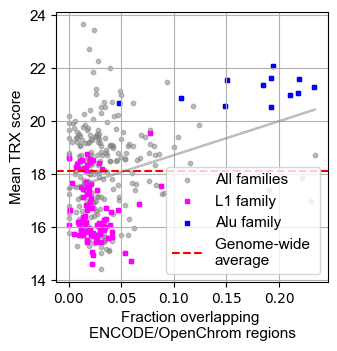

In [61]:

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


ax1.scatter(TRX_sorted_by_age_filterd["Mean overlap open chr."],TRX_sorted_by_age_filterd["Mean TRX"],marker="o",color="grey",label="All families",s=10,alpha=0.5)


ax1.scatter(TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="L1"]["Mean overlap open chr."],TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="L1"]["Mean TRX"],marker="s",color="magenta",label="L1 family",s=10)

ax1.scatter(TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="Alu"]["Mean overlap open chr."],TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="Alu"]["Mean TRX"],marker="s",color="blue",label="Alu family",s=10)

ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 

plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
plt.xlabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()




################
mean_overlap_open_chr_all=TRX_sorted_by_age_filterd["Mean overlap open chr."].tolist()
mean_TRX_all=TRX_sorted_by_age_filterd["Mean TRX"].tolist()
model_lin_3 = LinearRegression()
model_lin_3.fit(np.array(mean_overlap_open_chr_all).reshape(-1, 1),mean_TRX_all)
pred_mean_TRX_all=model_lin_3.predict(np.array(mean_overlap_open_chr_all).reshape(-1, 1))
r2_model_lin_3 = r2_score(mean_TRX_all, pred_mean_TRX_all)
print("R^2 model 1",r2_model_lin_3)
ax1.errorbar(mean_overlap_open_chr_all,pred_mean_TRX_all,color="grey",alpha=0.5)

x_3_ols_const=sm.add_constant(mean_overlap_open_chr_all)
y_3_ols=mean_TRX_all
model_sm3 = sm.OLS(y_3_ols, x_3_ols_const).fit()

# Get the p-values
p_values3 = model_sm3.pvalues
print("P-values intercept, slope model 3",p_values3)


# Calculate Pearson correlation
P_corr3, P_p_value3 = scipy.stats.pearsonr(mean_overlap_open_chr_all, mean_TRX_all)

print(f'Pearson correlation coefficient: {P_corr3}')
print(f'P-value: {P_p_value3}')


#plt.savefig("Transposon_analysis_1/figures/Mean_TRX_vs_frac_overl_open_chr_3.pdf",format="pdf",bbox_inches="tight")


In [62]:
#Names of sub-families
unique_v4 = [TRX_sorted_by_age_filterd[col_name].unique() for col_name in TRX_sorted_by_age_filterd.columns]

for i in unique_v4[2]:
    print(i)

TcMar-Mariner
L1
CR1
RTE
TcMar-Tigger
L2
hAT-Charlie
MIR
TcMar-Tc2
hAT-Tip100
ERVL-MaLR
hAT-Blackjack
ERVL
ERV1
hAT
Alu


Numnber of analyzed transposons: 321


/tmp/ipykernel_100/3032530539.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', num_colors)


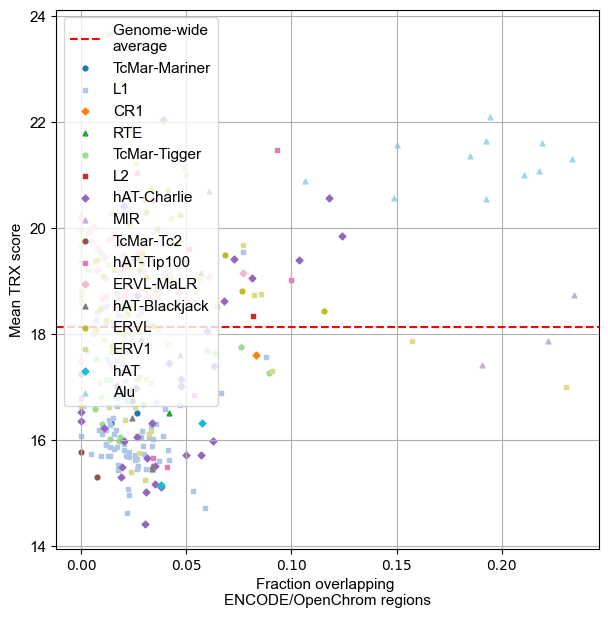

In [63]:
fig=plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(111)
ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")

def generate_colors(num_colors):
    colors = plt.cm.get_cmap('tab20', num_colors)
    return [colors(i) for i in range(num_colors)]
colors_1 = generate_colors(len(unique_v4[2]))
markers_1 = ['o', 's', 'D', '^']
for i in range(len(unique_v4[2])):
    fam_name=unique_v4[2][i]
    marker=markers_1[i%len(markers_1)]
    ###############
    overlap_open_chr=TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]==fam_name]["Mean overlap open chr."].tolist()
    TRX_mean=TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]==fam_name]["Mean TRX"].tolist()
    

    
    ##############
    ax1.scatter(overlap_open_chr,TRX_mean,marker=marker,label=fam_name,color=colors_1[i],s=12)
    #ax1.errorbar(age_index_sel3_ls,TRX_by_age_sel3_ls,fmt=".",label="ERV1 elements",color="orange")




plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 
#plt.xticks([0,100,200,300,400],["Oldest","","","","Youngest"],fontname = "Arial",fontsize=11) 


plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
plt.xlabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.grid()

print("Numnber of analyzed transposons:",len(TRX_sorted_by_age_filterd))

#plt.savefig("Transposon_analysis_1/figures/Mean_TRX_vs_frac_overl_open_chr_all_fam_1.pdf",format="pdf",bbox_inches="tight")


Text(0.5, 0, 'Chronological order')

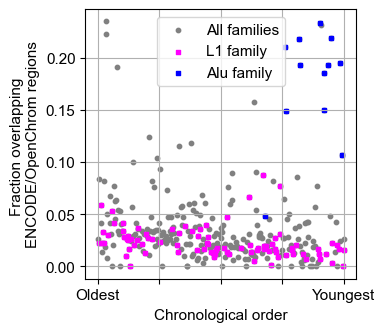

In [64]:

fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


ax1.scatter(TRX_sorted_by_age_filterd["Age index"],TRX_sorted_by_age_filterd["Mean overlap open chr."],marker="o",color="grey",label="All families",s=10)


ax1.scatter(TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="L1"]["Age index"],TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="L1"]["Mean overlap open chr."],marker="s",color="magenta",label="L1 family",s=10)

ax1.scatter(TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="Alu"]["Age index"],TRX_sorted_by_age_filterd[TRX_sorted_by_age_filterd["repFamily"]=="Alu"]["Mean overlap open chr."],marker="s",color="blue",label="Alu family",s=10)

#ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 

#plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
#plt.xlabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()

plt.xticks([0,100,200,300,400],["Oldest","","","","Youngest"],fontname = "Arial",fontsize=11) 

plt.ylabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.xlabel("Chronological order",fontname = "Arial",fontsize=11)

#plt.savefig("Transposon_analysis_1/figures/Mean_TRX_vs_frac_overl_open_chr_1.pdf",format="pdf",bbox_inches="tight")


## TRX against fraction of transposons in clusters

In [65]:
#list_TE_names_1b=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="L1"]["repName"].tolist()

#list_TE_names_2b=TRX_sorted_by_age[TRX_sorted_by_age["repFamily"]=="Alu"]["repName"].tolist()

#list_TE_names_3b=list_TE_names_1b+list_TE_names_2b


#list_TE_names_3b=TRX_sorted_by_age[~TRX_sorted_by_age["repFamily"].isin(["Alu","L1"])]["repName"].tolist()

list_TE_names_3b=TRX_sorted_by_age["repName"].tolist() #[TRX_sorted_by_age["repFamily"]=="Alu"]["repName"].tolist()

check_ref_list=rmd["repName"].tolist()
list_TE_names_3b=[item for item in list_TE_names_3b if item in check_ref_list ]
print(len(list_TE_names_3b))

360


In [76]:
%%time
dict_mean_fraction_elem_in_clusters=fraction_elem_in_clusters_1(list_TE_names=list_TE_names_3b,rmd=rmd,chr_list=chr_list,eps=1e4,min_samples=2)

MARNA
Charlie11
Error with Charlie11
L1MEd
L3
L1ME4a
L4
Tigger8
L1MEe
HAL1
HAL1b
L2
Charlie7
MIR3
MIRb
MER113
Kanga2_a
L1ME3B
MER102b
Charlie8
Charlie2b
L1M5
Zaphod2
Charlie2a
L1MC4a
MLT1K
MLT1L
Charlie9
MER20B
MIR
MLT1J
BLACKJACK
MER112
MER102a
Kanga1
Arthur1
Zaphod
L1MC4
L1MC5
L1ME3A
Charlie6
Error with Charlie6
L1MEb
L1ME3
L1MDa
L1MEc
L1MCc
L1MEa
Charlie4
Error with Charlie4
L1ME2
MER63D
Charlie4a
MER46C
MER91B
L1M
L1MDb
LTR33
MLT1J2
L1ME1
MLT1I
L1M4b
MER31-int
Charlie1a
FordPrefect_a
MER97c
Error with MER97c
L1MCa
MER115
MLT1H-int
LTR37B
L1MCb
L1M4
MLT1J1
LTR33A
L1M4c
Charlie10
MER117
Cheshire
LTR16C
L1MC
MER5B
LTR16A1
LTR50
MLT1H
FordPrefect
Charlie1b
MER5A
MLT1G
MLT1H2
MER5C
LTR16A
L1MD
MER91A
MLT1H1
MER91C
MER58D
LTR37A
MER57A-int
MADE2
MER97a
Charlie1
MER94
MLT2F
MER5A1
MLT1G1
MER119
MER97b
Error with MER97b
MER63C
MER3
MER63B
Charlie5
L1MD2
MER33
LTR16B
MER45R
MLT1F1
MER45C
L1MD1
MLT1F
L1MD3
L1MC3
LTR41
MER106A
MER63A
MER58C
MLT1F2
MER96B
MER58B
Tigger6a
Tigger6b
L1MB7
MER45B


In [67]:
dict_mean_fraction_elem_in_clusters

{'FAM': 0.09439154013455525,
 'AluJo': 0.5598249468965575,
 'FLAM_A': 0.1865379718303671,
 'AluJb': 0.7696059048782216,
 'FLAM_C': 0.3289750106869393,
 'AluSx': 0.749415294132786,
 'AluSc': 0.3032499574600754,
 'AluSq': 0.24852446602389092,
 'AluSg': 0.3785963459573569,
 'AluSp': 0.4705779119553935,
 'AluY': 0.6441940746835834,
 'FRAM': 0.18710226083654125,
 'AluYd8': None,
 'AluYg6': 0.04527209412334714,
 'AluYa5': 0.02866246317281028,
 'AluYb8': 0.025359508618869424}

In [66]:
#Save and load fraction of transposons in clusters

#with open ("Transposon_analysis_1/save_elements/dict_mean_fraction_elem_in_clusters.pkl","wb") as f:
    #pickle.dump(dict_mean_fraction_elem_in_clusters,f)


with open("Transposon_analysis_1/save_elements/dict_mean_fraction_elem_in_clusters.pkl", 'rb') as f:
    dict_mean_fraction_elem_in_clusters = pickle.load(f)

In [49]:
%%time
dict_mean_fraction_elem_in_clusters=parallel_fraction_elem_in_clusters_sel_1(num_workers=5,list_TE_names=list_TE_names_3b[5:10],rmd=rmd,chr_list=chr_list,eps=1e4,min_samples=2)

AluSx
AluSc
AluSq
AluSg
AluSp
Error with AluSq
Error with AluSc
Error with AluSg
Error with AluSp
Error with AluSx
CPU times: user 56 s, sys: 16 s, total: 1min 12s
Wall time: 1min 7s


In [67]:
# add mean percentage of overlap to dataframe
def add_dict_mean_fraction_elem_in_clusters(name):
    return dict_mean_fraction_elem_in_clusters.get(name, None)

TRX_sorted_by_age["Mean fraction in clusters"]=TRX_sorted_by_age["repName"].apply(add_dict_mean_fraction_elem_in_clusters) 

TRX_sorted_by_age_filterd2=TRX_sorted_by_age[TRX_sorted_by_age["Mean fraction in clusters"].notnull()]
TRX_sorted_by_age_filterd2

repName repClass      repFamily  Age index   Mean TRX  \
0     MARNA      DNA  TcMar-Mariner          0  16.522096   
2     L1MEd     LINE             L1          2  15.679691   
3        L3     LINE            CR1          3  17.600551   
4    L1ME4a     LINE             L1          5  14.715010   
5        L4     LINE            RTE          6  16.519028   
..      ...      ...            ...        ...        ...   
355   L1PA2     LINE             L1        400  18.232637   
356    LTR7      LTR           ERV1        401  21.217075   
357  AluYg6     SINE            Alu        402  21.838312   
358  AluYa5     SINE            Alu        403  22.650782   
359  AluYb8     SINE            Alu        404  22.780260   

     Mean overlap open chr.  Mean fraction in clusters  
0                  0.026612                   0.335454  
2                  0.022691                   0.805311  
3                  0.083291                   0.569450  
4                  0.058775                   0.680282  
5                  0.041948                   0.472327  
..                      ...                        ...  
355                0.015294                   0.345672  
356                0.025989                   0.658782  
357                     NaN                   0.045272  
358                     NaN                   0.028662  
359                     NaN                   0.025360  

[345 rows x 7 columns]

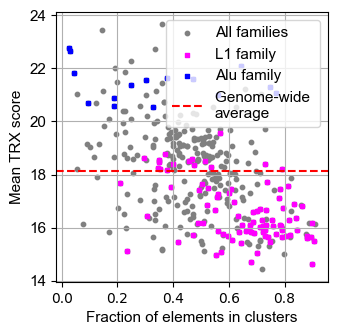

In [68]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


ax1.scatter(TRX_sorted_by_age_filterd2["Mean fraction in clusters"],TRX_sorted_by_age_filterd2["Mean TRX"],marker="o",color="grey",label="All families",s=10)


ax1.scatter(TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="L1"]["Mean fraction in clusters"],TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="L1"]["Mean TRX"],marker="s",color="magenta",label="L1 family",s=10)

ax1.scatter(TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="Alu"]["Mean fraction in clusters"],TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="Alu"]["Mean TRX"],marker="s",color="blue",label="Alu family",s=10)

ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 

plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
plt.xlabel("Fraction of elements in clusters",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()


Text(0.5, 0, 'Chronological order')

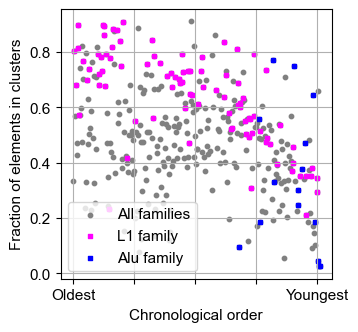

In [69]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


ax1.scatter(TRX_sorted_by_age_filterd2["Age index"],TRX_sorted_by_age_filterd2["Mean fraction in clusters"],marker="o",color="grey",label="All families",s=10)


ax1.scatter(TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="L1"]["Age index"],TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="L1"]["Mean fraction in clusters"],marker="s",color="magenta",label="L1 family",s=10)

ax1.scatter(TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="Alu"]["Age index"],TRX_sorted_by_age_filterd2[TRX_sorted_by_age_filterd2["repFamily"]=="Alu"]["Mean fraction in clusters"],marker="s",color="blue",label="Alu family",s=10)

#ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide \naverage")

plt.yticks(fontname = "Arial",fontsize=11) 
#plt.xticks([0,400],["Oldest","Youngest"],fontname = "Arial",fontsize=11) 

#plt.ylabel("Mean TRX score",fontname = "Arial",fontsize=11)
#plt.xlabel("Fraction overlapping \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)

plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()

plt.xticks([0,100,200,300,400],["Oldest","","","","Youngest"],fontname = "Arial",fontsize=11) 

plt.ylabel("Fraction of elements in clusters",fontname = "Arial",fontsize=11)
plt.xlabel("Chronological order",fontname = "Arial",fontsize=11)


In [64]:
TRX_sorted_by_age

repName repClass      repFamily  Age index   Mean TRX  \
0        MARNA      DNA  TcMar-Mariner          0  16.522096   
1    Charlie11      DNA    hAT-Charlie          1  15.866088   
2        L1MEd     LINE             L1          2  15.679691   
3           L3     LINE            CR1          3  17.600551   
4       L1ME4a     LINE             L1          5  14.715010   
..         ...      ...            ...        ...        ...   
355      L1PA2     LINE             L1        400  18.232637   
356       LTR7      LTR           ERV1        401  21.217075   
357     AluYg6     SINE            Alu        402  21.838312   
358     AluYa5     SINE            Alu        403  22.650782   
359     AluYb8     SINE            Alu        404  22.780260   

     Mean overlap open chr.  Mean fraction in clusters  
0                  0.026612                   0.335454  
1                       NaN                        NaN  
2                  0.022691                   0.805311  
3                  0.083291                   0.569450  
4                  0.058775                   0.680282  
..                      ...                        ...  
355                0.015294                   0.345672  
356                0.025989                   0.658782  
357                     NaN                   0.045272  
358                     NaN                   0.028662  
359                     NaN                   0.025360  

[360 rows x 7 columns]

In [92]:
#save df with mean TRX, age index, mean overlap with open chr and mean fraction of transposons in clusters
#TRX_sorted_by_age.to_csv("Transposon_analysis_1/save_elements/TRX_overlap_open_chr_fraction_clusters_sorted_by_age.csv", index=False)

# Check fraction of transposons in A/B compartments

In [70]:
rmd

genoName  genoStart   genoEnd     repName repClass  \
0                         chr1   16777160  16777470       AluSp     SINE   
1                         chr1   25165800  25166089        AluY     SINE   
2                         chr1   33553606  33554646         L2b     LINE   
3                         chr1   50330063  50332153      L1PA10     LINE   
4                         chr1   58720067  58720973       L1PA2     LINE   
...                        ...        ...       ...         ...      ...   
5481336  chr21_gl000210_random      25378     25875      MER74B      LTR   
5481337  chr21_gl000210_random      26437     26596        MIRc     SINE   
5481338  chr21_gl000210_random      26881     27022        MIRc     SINE   
5481339  chr21_gl000210_random      27296     27447  HAL1-2a_MD     LINE   
5481340  chr21_gl000210_random      27468     27682  HAL1-2a_MD     LINE   

        repFamily  
0             Alu  
1             Alu  
2              L2  
3              L1  
4              L1  
...           ...  
5481336      ERVL  
5481337       MIR  
5481338       MIR  
5481339        L1  
5481340        L1  

[5481341 rows x 6 columns]

In [82]:
#A/B comp. data only of autosome, filter TEs on autosomes
chr_list_aut=["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15","chr16",
         "chr17","chr18","chr19","chr20","chr21","chr22"]
rmd_aut=rmd[rmd["genoName"].isin(chr_list_aut)]
rmd_aut

genoName  genoStart   genoEnd repName repClass repFamily
0           chr1   16777160  16777470   AluSp     SINE       Alu
1           chr1   25165800  25166089    AluY     SINE       Alu
2           chr1   33553606  33554646     L2b     LINE        L2
3           chr1   50330063  50332153  L1PA10     LINE        L1
4           chr1   58720067  58720973   L1PA2     LINE        L1
...          ...        ...       ...     ...      ...       ...
5232236    chr22   51243194  51243802    L1MC     LINE        L1
5232237    chr22   51243818  51243924   LTR60      LTR      ERV1
5232238    chr22   51244035  51244339  AluYb8     SINE       Alu
5232239    chr22   51244339  51244456   LTR60      LTR      ERV1
5232240    chr22   51244456  51244541   LTR60      LTR      ERV1

[4923664 rows x 6 columns]

In [71]:
AB_HeLa

CHROM     START      STOP Compartment  C5 C6        C7        C8  \
0       chr1         0    100000          B1   0  .         0    100000   
1       chr1    100000    200000          B1   0  .    100000    200000   
2       chr1    200000    300000          B1   0  .    200000    300000   
3       chr1    300000    400000          B3   0  .    300000    400000   
4       chr1    400000    500000          B3   0  .    400000    500000   
...      ...       ...       ...         ...  .. ..       ...       ...   
26982  chr22  50800000  50900000          A1   0  .  50800000  50900000   
26983  chr22  50900000  51000000          A1   0  .  50900000  51000000   
26984  chr22  51000000  51100000          A1   0  .  51000000  51100000   
26985  chr22  51100000  51200000          A2   0  .  51100000  51200000   
26986  chr22  51200000  51300000          A2   0  .  51200000  51300000   

                C9  
0        220,20,60  
1        220,20,60  
2        220,20,60  
3      112,128,144  
4      112,128,144  
...            ...  
26982    34,139,34  
26983    34,139,34  
26984    34,139,34  
26985  152,251,152  
26986  152,251,152  

[26987 rows x 9 columns]

In [72]:
AB_HeLa_fA

CHROM     START      STOP Compartment  C5 C6        C7        C8  \
5       chr1    500000    600000          A2   0  .    500000    600000   
6       chr1    600000    700000          A2   0  .    600000    700000   
7       chr1    700000    800000          A1   0  .    700000    800000   
9       chr1    900000   1000000          A1   0  .    900000   1000000   
10      chr1   1000000   1100000          A1   0  .   1000000   1100000   
...      ...       ...       ...         ...  .. ..       ...       ...   
26982  chr22  50800000  50900000          A1   0  .  50800000  50900000   
26983  chr22  50900000  51000000          A1   0  .  50900000  51000000   
26984  chr22  51000000  51100000          A1   0  .  51000000  51100000   
26985  chr22  51100000  51200000          A2   0  .  51100000  51200000   
26986  chr22  51200000  51300000          A2   0  .  51200000  51300000   

                C9  
5      152,251,152  
6      152,251,152  
7        34,139,34  
9        34,139,34  
10       34,139,34  
...            ...  
26982    34,139,34  
26983    34,139,34  
26984    34,139,34  
26985  152,251,152  
26986  152,251,152  

[13390 rows x 9 columns]

In [83]:
rmd_Alu_aut=rmd_aut[rmd_aut["repFamily"]=="Alu"]
rmd_Alu_aut

genoName  genoStart    genoEnd repName repClass repFamily
0           chr1   16777160   16777470   AluSp     SINE       Alu
1           chr1   25165800   25166089    AluY     SINE       Alu
11          chr1  150994892  150995191    AluY     SINE       Alu
13          chr1  167772064  167772362  AluSq2     SINE       Alu
18          chr1    1048297    1048591  AluSx1     SINE       Alu
...          ...        ...        ...     ...      ...       ...
5232183    chr22   51221530   51221677    FRAM     SINE       Alu
5232204    chr22   51234020   51234285   AluJb     SINE       Alu
5232209    chr22   51236033   51236334    AluY     SINE       Alu
5232232    chr22   51241278   51241585  AluSq2     SINE       Alu
5232238    chr22   51244035   51244339  AluYb8     SINE       Alu

[1118248 rows x 6 columns]

In [92]:
%%time
#Alu_overlap_A=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_Alu_aut[:], df2=AB_HeLa_fA, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=0)
Alu_overlap_B=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_Alu_aut[:], df2=AB_HeLa_fB, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=0)


CPU times: user 12min 39s, sys: 0 ns, total: 12min 39s
Wall time: 12min 39s


In [93]:
print(np.mean(Alu_overlap_A))

0.7335591031685279


In [94]:
rmd_Alu_aut["overlap with A comp."]=Alu_overlap_A

/tmp/ipykernel_100/796608224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmd_Alu_aut["overlap with A comp."]=Alu_overlap_A


In [127]:
rmd_Alu_aut["overlap with B comp."]=Alu_overlap_B

/tmp/ipykernel_100/1415226567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmd_Alu_aut["overlap with B comp."]=list_Alu_aut_overlap_with_B_comp    #Alu_overlap_B


In [129]:
#save and load df with A/B overlap
#rmd_Alu_aut.to_csv("Transposon_analysis_1/save_elements/rmd_Alu_aut_overlap_with_A_B_comp.csv", index=False)

#rmd_Alu_aut=pd.read_csv("Transposon_analysis_1/save_elements/rmd_Alu_aut_overlap_with_A_B_comp.csv")

In [128]:
rmd_Alu_aut

genoName  genoStart    genoEnd repName repClass repFamily  \
0           chr1   16777160   16777470   AluSp     SINE       Alu   
1           chr1   25165800   25166089    AluY     SINE       Alu   
11          chr1  150994892  150995191    AluY     SINE       Alu   
13          chr1  167772064  167772362  AluSq2     SINE       Alu   
18          chr1    1048297    1048591  AluSx1     SINE       Alu   
...          ...        ...        ...     ...      ...       ...   
5232183    chr22   51221530   51221677    FRAM     SINE       Alu   
5232204    chr22   51234020   51234285   AluJb     SINE       Alu   
5232209    chr22   51236033   51236334    AluY     SINE       Alu   
5232232    chr22   51241278   51241585  AluSq2     SINE       Alu   
5232238    chr22   51244035   51244339  AluYb8     SINE       Alu   

         overlap with A comp.  overlap with B comp.  
0                           1                   0.0  
1                           1                   0.0  
11                          1                   0.0  
13                          1                   0.0  
18                          1                   0.0  
...                       ...                   ...  
5232183                     1                   0.0  
5232204                     1                   0.0  
5232209                     1                   0.0  
5232232                     1                   0.0  
5232238                     1                   0.0  

[1118248 rows x 8 columns]

In [132]:
#filter out rows with no A/B assignment of assignment to both
rmd_Alu_aut_f=rmd_Alu_aut[(rmd_Alu_aut["overlap with B comp."] +rmd_Alu_aut["overlap with A comp."])==1]
rmd_Alu_aut_f

genoName  genoStart    genoEnd repName repClass repFamily  \
0           chr1   16777160   16777470   AluSp     SINE       Alu   
1           chr1   25165800   25166089    AluY     SINE       Alu   
11          chr1  150994892  150995191    AluY     SINE       Alu   
13          chr1  167772064  167772362  AluSq2     SINE       Alu   
18          chr1    1048297    1048591  AluSx1     SINE       Alu   
...          ...        ...        ...     ...      ...       ...   
5232183    chr22   51221530   51221677    FRAM     SINE       Alu   
5232204    chr22   51234020   51234285   AluJb     SINE       Alu   
5232209    chr22   51236033   51236334    AluY     SINE       Alu   
5232232    chr22   51241278   51241585  AluSq2     SINE       Alu   
5232238    chr22   51244035   51244339  AluYb8     SINE       Alu   

         overlap with A comp.  overlap with B comp.  
0                           1                   0.0  
1                           1                   0.0  
11                          1                   0.0  
13                          1                   0.0  
18                          1                   0.0  
...                       ...                   ...  
5232183                     1                   0.0  
5232204                     1                   0.0  
5232209                     1                   0.0  
5232232                     1                   0.0  
5232238                     1                   0.0  

[1118028 rows x 8 columns]

In [100]:
################
################

In [101]:
rmd_L1_aut=rmd_aut[rmd_aut["repFamily"]=="L1"]
rmd_L1_aut

genoName  genoStart    genoEnd repName repClass repFamily
3           chr1   50330063   50332153  L1PA10     LINE        L1
4           chr1   58720067   58720973   L1PA2     LINE        L1
5           chr1   75496180   75498100   L1MB7     LINE        L1
8           chr1  117440426  117440514   L1ME1     LINE        L1
9           chr1  117440494  117441457   L1ME1     LINE        L1
...          ...        ...        ...     ...      ...       ...
5232156    chr22   51203510   51204290   L1MB4     LINE        L1
5232199    chr22   51231575   51232931   L1MC3     LINE        L1
5232201    chr22   51233375   51233780   L1MC3     LINE        L1
5232234    chr22   51242434   51242625    L1MC     LINE        L1
5232236    chr22   51243194   51243802    L1MC     LINE        L1

[862941 rows x 6 columns]

In [117]:
%%time
L1_overlap_A=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_L1_aut[:], df2=AB_HeLa_fA, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=0)
#L1_overlap_B=check_if_df1_entries_are_overlapped_by_df2_entries_V1(df1=rmd_L1_aut[:], df2=AB_HeLa_fB, chr_name_1="genoName",start_name_1="genoStart",stop_name_1="genoEnd", chr_name_2="CHROM",start_name_2="START",stop_name_2="STOP",min_dist=0)

CPU times: user 10min 3s, sys: 127 ms, total: 10min 3s
Wall time: 10min 3s


In [118]:
print(np.mean(L1_overlap_A))

0.4896163237115863


In [103]:
print(np.mean(L1_overlap_B))

0.510790424837851


In [119]:
print(np.mean(L1_overlap_A)+np.mean(L1_overlap_B))

1.0004067485494372


In [120]:
rmd_L1_aut["overlap with A comp."]=L1_overlap_A

/tmp/ipykernel_100/2364880045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmd_L1_aut["overlap with A comp."]=L1_overlap_A


In [104]:
rmd_L1_aut["overlap with B comp."]=L1_overlap_B

/tmp/ipykernel_100/4222683781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmd_L1_aut["overlap with B comp."]=L1_overlap_B


In [122]:

#save and load df with A/B overlap

#rmd_L1_aut.to_csv("Transposon_analysis_1/save_elements/rmd_L1_aut_overlap_with_A_B_comp.csv", index=False)

#rmd_L1_aut=pd.read_csv("Transposon_analysis_1/save_elements/rmd_L1_aut_overlap_with_A_B_comp.csv")


In [121]:
rmd_L1_aut

genoName  genoStart    genoEnd repName repClass repFamily  \
3           chr1   50330063   50332153  L1PA10     LINE        L1   
4           chr1   58720067   58720973   L1PA2     LINE        L1   
5           chr1   75496180   75498100   L1MB7     LINE        L1   
8           chr1  117440426  117440514   L1ME1     LINE        L1   
9           chr1  117440494  117441457   L1ME1     LINE        L1   
...          ...        ...        ...     ...      ...       ...   
5232156    chr22   51203510   51204290   L1MB4     LINE        L1   
5232199    chr22   51231575   51232931   L1MC3     LINE        L1   
5232201    chr22   51233375   51233780   L1MC3     LINE        L1   
5232234    chr22   51242434   51242625    L1MC     LINE        L1   
5232236    chr22   51243194   51243802    L1MC     LINE        L1   

         overlap with B comp.  overlap with A comp.  
3                           1                     0  
4                           1                     0  
5                           1                     0  
8                           1                     0  
9                           1                     0  
...                       ...                   ...  
5232156                     0                     1  
5232199                     0                     1  
5232201                     0                     1  
5232234                     0                     1  
5232236                     0                     1  

[862941 rows x 8 columns]

In [130]:
#filter out rows with no A/B assignment of assignment to both
rmd_L1_aut_f=rmd_L1_aut[(rmd_L1_aut["overlap with B comp."] +rmd_L1_aut["overlap with A comp."])==1]
rmd_L1_aut_f

genoName  genoStart    genoEnd repName repClass repFamily  \
3           chr1   50330063   50332153  L1PA10     LINE        L1   
4           chr1   58720067   58720973   L1PA2     LINE        L1   
5           chr1   75496180   75498100   L1MB7     LINE        L1   
8           chr1  117440426  117440514   L1ME1     LINE        L1   
9           chr1  117440494  117441457   L1ME1     LINE        L1   
...          ...        ...        ...     ...      ...       ...   
5232156    chr22   51203510   51204290   L1MB4     LINE        L1   
5232199    chr22   51231575   51232931   L1MC3     LINE        L1   
5232201    chr22   51233375   51233780   L1MC3     LINE        L1   
5232234    chr22   51242434   51242625    L1MC     LINE        L1   
5232236    chr22   51243194   51243802    L1MC     LINE        L1   

         overlap with B comp.  overlap with A comp.  
3                           1                     0  
4                           1                     0  
5                           1                     0  
8                           1                     0  
9                           1                     0  
...                       ...                   ...  
5232156                     0                     1  
5232199                     0                     1  
5232201                     0                     1  
5232234                     0                     1  
5232236                     0                     1  

[862512 rows x 8 columns]

In [133]:
##########################
##########################

In [107]:

AB_HeLa_fA_len=AB_HeLa_fA["STOP"]-AB_HeLa_fA["START"]
AB_HeLa_fA_tot_len=AB_HeLa_fA_len.sum()
print("Length of annotated A comp.:",AB_HeLa_fA_tot_len/10**9 ,"Giga bases")


AB_HeLa_fB_len=AB_HeLa_fB["STOP"]-AB_HeLa_fB["START"]
AB_HeLa_fB_tot_len=AB_HeLa_fB_len.sum()
print("Length of annotated B comp.:",AB_HeLa_fB_tot_len/10**9 ,"Giga bases")

Length of annotated A comp.: 1.338787678 Giga bases
Length of annotated B comp.: 1.359335487 Giga bases


In [134]:
overlap_allAlu_A=rmd_Alu_aut_f["overlap with A comp."].tolist()
overlap_AluSp=rmd_Alu_aut_f[rmd_Alu_aut_f["repName"]=="AluSp"]["overlap with A comp."].tolist()
overlap_AluY=rmd_Alu_aut_f[rmd_Alu_aut_f["repName"]=="AluY"]["overlap with A comp."].tolist()

print("Mean + Std of overlap with A comp. for all Alu:",np.mean(overlap_allAlu_A),np.std(overlap_allAlu_A))
print("Mean + Std of overlap with A comp. for AluSp:",np.mean(overlap_AluSp),np.std(overlap_AluSp))
print("Mean + Std of overlap with A comp.for AluY:",np.mean(overlap_AluY),np.std(overlap_AluY))

Mean + Std of overlap with A comp. for all Alu: 0.7335442403946949 0.4421052903760199
Mean + Std of overlap with A comp. for AluSp: 0.7497482915961526 0.4331579282949847
Mean + Std of overlap with A comp.for AluY: 0.6495681828247487 0.47710518618696923


In [131]:
overlap_allL1_A=rmd_L1_aut_f["overlap with B comp."].tolist()
overlap_L1ME1=rmd_L1_aut_f[rmd_L1_aut_f["repName"]=="L1ME1"]["overlap with B comp."].tolist()
overlap_L1HS=rmd_L1_aut_f[rmd_L1_aut_f["repName"]=="L1HS"]["overlap with B comp."].tolist()

print("Mean + Std of overlap with B comp. for all L1:",np.mean(overlap_allL1_A),np.std(overlap_allL1_A))
print("Mean + Std of overlap with B comp. for L1ME1:",np.mean(overlap_L1ME1),np.std(overlap_L1ME1))
print("Mean + Std of overlap with B comp. for L1HS:",np.mean(overlap_L1HS),np.std(overlap_L1HS))

Mean + Std of overlap with B comp. for all L1: 0.5105923163967574 0.4998877902423213
Mean + Std of overlap with B comp. for L1ME1: 0.46885731600565617 0.4990291907630539
Mean + Std of overlap with B comp. for L1HS: 0.7272058823529411 0.4453958767481143


# MNase data

In [7]:
#https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100401
#https://pmc.ncbi.nlm.nih.gov/articles/PMC6379673/#SEC5

In [7]:
#from analyzing_genome_sections_6

#obtain ChIP-Seq data coverage from bigwig files for genes in dataframe
#return dataframe with gene annotation column for ChIP-Seq signal
#-1 are filled in instead of signal if problems/error with data retrival occurs
def get_coverage_for_genes_V1(df_genes,ID_col,Name_col,Chr_col,Start_col,Stop_col,Orientation_col,Signal_col,expected_dim,add_interval,big_wig_file_name,chr_add="chr",signal_type="mean"):
    #(names_list, chr_list, pos_start_list, pos_end_list, orientation_list, big_wig_file_name,intervall_at_pos,expected_dim,signal_type="mean")
    #names_list2=[]
    #chr_list2=[]
    #pos_list2=[]
    #orientation_list2=[]
    
    #return_coverage_dict={}
    chip_seq_signal=[]
    
    #lists of boundaries for signal read in
    list_lower_int_b=[]
    list_upper_int_b=[]
    
    for index, row in df_genes.iterrows():
        #get chromosome of the selected gene, possibly with name add i.e. 12->chr12
        #print(row[Chr_col])
        if chr_add!=None:
            gene_chr=chr_add+row[Chr_col]
        else:
            gene_chr=row[Chr_col]
        
        #get start stop pos of selected gene and increase by interval
        gene_lower_int_b=int(row[Start_col]-add_interval)
        gene_upper_int_b=int(row[Stop_col]+add_interval)
        
        list_lower_int_b.append(gene_lower_int_b)
        list_upper_int_b.append(gene_upper_int_b)
        
        #check if negative boundaries 
        if gene_lower_int_b>=0 and gene_upper_int_b>=0:
            try:
                big_wig_signal=big_wig_file_name.stats(gene_chr,gene_lower_int_b ,gene_upper_int_b,type=signal_type,nBins=expected_dim)
                print(row[ID_col],row[Name_col],gene_chr,gene_lower_int_b ,gene_upper_int_b,signal_type,expected_dim)
                if len(big_wig_signal)==expected_dim:
                    if expected_dim==1:#for sum of signal no need for additional brakets [1,2,3,...]
                        chip_seq_signal.append(big_wig_signal[0])
                    else:# longer sequences [[1,2,3],[2,3,4],...]
                        chip_seq_signal.append(big_wig_signal)
                #case of wrong dimension for chip seq read in
                else:
                    print("dimension error when trying to get data for ",row[ID_col],row[Name_col],len(big_wig_signal))

                    #chip_seq_signal.append("error")
                    chip_seq_signal.append(-np.ones(expected_dim))
                    
            #case of failed chipseq read in    
            except:
                print("error when trying to get data for ",row[ID_col],row[Name_col])

                #chip_seq_signal.append("error") 
                chip_seq_signal.append(-np.ones(expected_dim))
                
        #case of negative interval boundaries
        else:
            print("negative interval boundaries when trying to get data for ",row[ID_col],row[Name_col],gene_lower_int_b,gene_upper_int_b)

            #chip_seq_signal.append("error")             
            chip_seq_signal.append(-np.ones(expected_dim))
            
        print(index,"/",len(df_genes)-1)
        
        #filters out None
        if expected_dim!=1:
            chip_seq_signal_drop_nan=[[0 if item is None else item for item in inner_list] for inner_list in chip_seq_signal]
        if expected_dim==1:
            chip_seq_signal_drop_nan=[0 if item is None else item for item in chip_seq_signal]
            
    return_coverage_dict={"ID":df_genes[ID_col].tolist(),
                         "Name":df_genes[Name_col].tolist(),
                         "Chr":df_genes[Chr_col].tolist(),
                         "Signal start":list_lower_int_b,
                         "Signal stop":list_upper_int_b,
                         "Orientation":df_genes[Orientation_col].tolist(),
                         Signal_col:chip_seq_signal_drop_nan}

    return_coverage_df=pd.DataFrame(return_coverage_dict)
    return return_coverage_df

In [44]:
#append list of TEs split by chr into dataframe
rmd_list_1_all_chr=pd.concat(rmd_list_1,ignore_index=True)
rmd_rd_list_1_all_chr=pd.concat(rmd_rd_list_1,ignore_index=True)

rmd_list_2_all_chr=pd.concat(rmd_list_2,ignore_index=True)
rmd_rd_list_2_all_chr=pd.concat(rmd_rd_list_2,ignore_index=True)

In [107]:
#bw_MNase_HeLa= pyBigWig.open("Transposon_analysis_1/MNase_Hela/GSM2680346_adj.low.r1.1n.nucOcc.bw")
bw_MNase_HeLa= pyBigWig.open("Transposon_analysis_1/ATAC_seq_Hela_S3/hg19_GSE121840_MOAM-HeLa-NS-C_ALL.bam.single_end.sort.bedGraph.bin.20bp.bed.gz.norm.bw.bw")


# Access chromosome lengths
chrom_lengths = bw_MNase_HeLa.chroms()
print(chrom_lengths)
#no X/Y chromosome in dataset

{'chr1': 249250621, 'chr10': 135534747, 'chr11': 135006516, 'chr11_gl000202_random': 40103, 'chr12': 133851895, 'chr13': 115169878, 'chr14': 107349540, 'chr15': 102531392, 'chr16': 90354753, 'chr17': 81195210, 'chr17_gl000203_random': 37498, 'chr17_gl000204_random': 81310, 'chr17_gl000205_random': 174588, 'chr18': 78077248, 'chr18_gl000207_random': 4262, 'chr19': 59128983, 'chr19_gl000208_random': 92689, 'chr19_gl000209_random': 159169, 'chr1_gl000191_random': 106433, 'chr1_gl000192_random': 547496, 'chr2': 243199373, 'chr20': 63025520, 'chr21': 48129895, 'chr22': 51304566, 'chr3': 198022430, 'chr4': 191154276, 'chr4_gl000193_random': 189789, 'chr4_gl000194_random': 191469, 'chr5': 180915260, 'chr6': 171115067, 'chr7': 159138663, 'chr7_gl000195_random': 182896, 'chr8': 146364022, 'chr8_gl000196_random': 38914, 'chr9': 141213431, 'chr9_gl000198_random': 90085, 'chr9_gl000199_random': 169874, 'chr9_gl000200_random': 187035, 'chrM': 16571, 'chrUn_gl000211': 166566, 'chrUn_gl000212': 18685

In [113]:
mean_MNase_rmd_1=get_coverage_for_genes_V1(df_genes=rmd_list_1_all_chr,ID_col="repName",Name_col="repName",Chr_col="genoName",Start_col="genoStart",Stop_col="genoEnd",Orientation_col="genoName",Signal_col="MNase",expected_dim=100,add_interval=50000,big_wig_file_name=bw_MNase_HeLa,chr_add=None,signal_type="mean")


L1HS L1HS chr1 158152916 158253980 mean 100
0 / 1492
L1HS L1HS chr1 237188564 237294593 mean 100
1 / 1492
L1HS L1HS chr1 14534205 14634450 mean 100
2 / 1492
L1HS L1HS chr1 29262345 29362694 mean 100
3 / 1492
L1HS L1HS chr1 30990660 31091597 mean 100
4 / 1492
L1HS L1HS chr1 34981675 35087706 mean 100
5 / 1492
L1HS L1HS chr1 35900408 36000601 mean 100
6 / 1492
L1HS L1HS chr1 41623423 41724113 mean 100
7 / 1492
L1HS L1HS chr1 42270194 42370987 mean 100
8 / 1492
L1HS L1HS chr1 42270986 42371231 mean 100
9 / 1492
L1HS L1HS chr1 42405394 42506037 mean 100
10 / 1492
L1HS L1HS chr1 51333863 51434638 mean 100
11 / 1492
L1HS L1HS chr1 56781124 56884954 mean 100
12 / 1492
L1HS L1HS chr1 58530618 58631671 mean 100
13 / 1492
L1HS L1HS chr1 59948667 60050000 mean 100
14 / 1492
L1HS L1HS chr1 60694057 60794314 mean 100
15 / 1492
L1HS L1HS chr1 60694313 60795128 mean 100
16 / 1492
L1HS L1HS chr1 63655411 63756233 mean 100
17 / 1492
L1HS L1HS chr1 63656226 63758163 mean 100
18 / 1492
L1HS L1HS chr1 658

In [114]:
mean_MNase_rmd_rd_1=get_coverage_for_genes_V1(df_genes=rmd_rd_list_1_all_chr,ID_col="REGION_ID",Name_col="REGION_ID",Chr_col="CHROM",Start_col="START",Stop_col="STOP",Orientation_col="REGION_ID",Signal_col="Control MNase",expected_dim=100,add_interval=50000,big_wig_file_name=bw_MNase_HeLa,chr_add=None,signal_type="mean")


0 0 chr1 206622783 206723847 mean 100
0 / 1492
1 1 chr1 78153181 78259210 mean 100
1 / 1492
2 2 chr1 193108746 193208991 mean 100
2 / 1492
3 3 chr1 89016703 89117052 mean 100
3 / 1492
4 4 chr1 214052564 214153500 mean 100
4 / 1492
5 5 chr1 142269470 142375500 mean 100
5 / 1492
6 6 chr1 115125772 115225964 mean 100
6 / 1492
7 7 chr1 129402814 129503504 mean 100
7 / 1492
8 8 chr1 56226258 56327051 mean 100
8 / 1492
9 9 chr1 114827242 114927486 mean 100
9 / 1492
10 10 chr1 172140290 172240933 mean 100
10 / 1492
11 11 chr1 161578822 161679598 mean 100
11 / 1492
12 12 chr1 195211102 195314932 mean 100
12 / 1492
13 13 chr1 156788424 156889476 mean 100
13 / 1492
14 14 chr1 142942399 143043732 mean 100
14 / 1492
15 15 chr1 62011656 62111912 mean 100
15 / 1492
16 16 chr1 118961951 119062766 mean 100
16 / 1492
17 17 chr1 126785470 126886292 mean 100
17 / 1492
18 18 chr1 123059387 123161324 mean 100
18 / 1492
19 19 chr1 155082110 155182364 mean 100
19 / 1492
20 20 chr1 242778944 242884999 mean 10

In [115]:
mean_MNase_TE_and_Ctr_1 = pd.DataFrame({'MNase': mean_MNase_rmd_1["MNase"], 'Control MNase': mean_MNase_rmd_rd_1["Control MNase"]})

In [57]:
#######

In [62]:
mean_MNase_rmd_2=get_coverage_for_genes_V1(df_genes=rmd_list_2_all_chr,ID_col="repName",Name_col="repName",Chr_col="genoName",Start_col="genoStart",Stop_col="genoEnd",Orientation_col="genoName",Signal_col="MNase",expected_dim=1,add_interval=0,big_wig_file_name=bw_MNase_HeLa,chr_add=None,signal_type="mean")


AluSp AluSp chr1 16777160 16777470 mean 1
0 / 48742
AluSp AluSp chr1 27262667 27262980 mean 1
1 / 48742
AluSp AluSp chr1 205520641 205520931 mean 1
2 / 48742
AluSp AluSp chr1 219152248 219152545 mean 1
3 / 48742
AluSp AluSp chr1 3669874 3670198 mean 1
4 / 48742
AluSp AluSp chr1 13369234 13369535 mean 1
5 / 48742
AluSp AluSp chr1 62128052 62128352 mean 1
6 / 48742
AluSp AluSp chr1 66453281 66453594 mean 1
7 / 48742
AluSp AluSp chr1 89259772 89260068 mean 1
8 / 48742
AluSp AluSp chr1 26790 27053 mean 1
9 / 48742
AluSp AluSp chr1 144605 144899 mean 1
10 / 48742
AluSp AluSp chr1 167133 167433 mean 1
11 / 48742
AluSp AluSp chr1 174517 174820 mean 1
12 / 48742
AluSp AluSp chr1 175598 175891 mean 1
13 / 48742
AluSp AluSp chr1 387180 387470 mean 1
14 / 48742
AluSp AluSp chr1 680292 680589 mean 1
15 / 48742
AluSp AluSp chr1 702958 703261 mean 1
16 / 48742
AluSp AluSp chr1 710306 710610 mean 1
17 / 48742
AluSp AluSp chr1 711380 711673 mean 1
18 / 48742
AluSp AluSp chr1 723464 723743 mean 1
19 / 

In [63]:
mean_MNase_rmd_rd_2=get_coverage_for_genes_V1(df_genes=rmd_rd_list_2_all_chr,ID_col="REGION_ID",Name_col="REGION_ID",Chr_col="CHROM",Start_col="START",Stop_col="STOP",Orientation_col="REGION_ID",Signal_col="Control MNase",expected_dim=1,add_interval=0,big_wig_file_name=bw_MNase_HeLa,chr_add=None,signal_type="mean")


0 0 chr1 62815248 62815558 mean 1
0 / 48742
1 1 chr1 121965179 121965492 mean 1
1 / 48742
2 2 chr1 39545124 39545414 mean 1
2 / 48742
3 3 chr1 70953410 70953707 mean 1
3 / 48742
4 4 chr1 106547093 106547417 mean 1
4 / 48742
5 5 chr1 168392180 168392481 mean 1
5 / 48742
6 6 chr1 34397819 34398119 mean 1
6 / 48742
7 7 chr1 139676830 139677144 mean 1
7 / 48742
8 8 chr1 197280274 197280570 mean 1
8 / 48742
9 9 chr1 143874102 143874364 mean 1
9 / 48742
10 10 chr1 204756104 204756398 mean 1
10 / 48742
11 11 chr1 42752418 42752718 mean 1
11 / 48742
12 12 chr1 91337258 91337562 mean 1
12 / 48742
13 13 chr1 48687420 48687714 mean 1
13 / 48742
14 14 chr1 7212566 7212856 mean 1
14 / 48742
15 15 chr1 233739524 233739822 mean 1
15 / 48742
16 16 chr1 236431614 236431918 mean 1
16 / 48742
17 17 chr1 108927898 108928202 mean 1
17 / 48742
18 18 chr1 195937977 195938270 mean 1
18 / 48742
19 19 chr1 83988228 83988506 mean 1
19 / 48742
20 20 chr1 32487891 32488186 mean 1
20 / 48742
21 21 chr1 19659758 196

In [64]:
mean_MNase_TE_and_Ctr_2 = pd.DataFrame({'MNase': mean_MNase_rmd_2["MNase"], 'Control MNase': mean_MNase_rmd_rd_2["Control MNase"]})

In [116]:
#need to filter out [-1.0] entries that were added for chromsomomes not found in the MNase dataset
#count non-numeric entries in a row
def count_non_numeric(row):
    return row.apply(lambda x: not isinstance(x, (int, float))).sum()
def has_list_with_neg_one(row):
    return any(isinstance(x, list) and -1 in x for x in row)
'''#filter out rows with one or two non-numeric entries
f_mean_MNase_TE_and_Ctr_1 = mean_MNase_TE_and_Ctr_1[mean_MNase_TE_and_Ctr_1.apply(count_non_numeric, axis=1) != 1]
f_mean_MNase_TE_and_Ctr_1 = f_mean_MNase_TE_and_Ctr_1[f_mean_MNase_TE_and_Ctr_1.apply(count_non_numeric, axis=1) != 2]
f_mean_MNase_TE_and_Ctr_1


#filter out rows with one or two non-numeric entries
f_mean_MNase_TE_and_Ctr_2 = mean_MNase_TE_and_Ctr_2[mean_MNase_TE_and_Ctr_2.apply(count_non_numeric, axis=1) != 1]
f_mean_MNase_TE_and_Ctr_2 = f_mean_MNase_TE_and_Ctr_2[f_mean_MNase_TE_and_Ctr_2.apply(count_non_numeric, axis=1) != 2]
f_mean_MNase_TE_and_Ctr_2'''

f_mean_MNase_TE_and_Ctr_1=mean_MNase_TE_and_Ctr_1[~mean_MNase_TE_and_Ctr_1.apply(has_list_with_neg_one,axis=1)]

f_mean_MNase_TE_and_Ctr_2=mean_MNase_TE_and_Ctr_2[~mean_MNase_TE_and_Ctr_2.apply(has_list_with_neg_one,axis=1)]

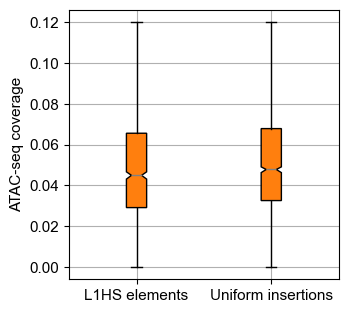

In [71]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
mean_MNase_all=[f_mean_MNase_TE_and_Ctr_1["MNase"].values,f_mean_MNase_TE_and_Ctr_1["Control MNase"].values]
#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

#bp1=ax1.boxplot(mean_MNase_all,positions=x_pos,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp1=ax1.boxplot(mean_MNase_all,positions=x_pos,showfliers=False,notch=True,bootstrap=100, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})

#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
#ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["L1HS elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("ATAC-seq coverage",fontname = "Arial",fontsize=11)

#plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

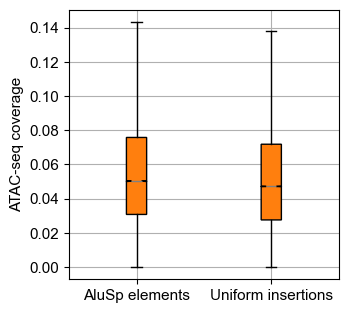

In [68]:
fig=plt.figure(figsize=(3.5,3.5))
ax1 = fig.add_subplot(111)


x_pos=np.asarray([0,1])
mean_MNase_all=[f_mean_MNase_TE_and_Ctr_2["MNase"].values,f_mean_MNase_TE_and_Ctr_2["Control MNase"].values]
#TRX_hom_pos=[TRX_rd_cluster_all_chr,TRX_rd_no_cluster_all_chr]

#ax1.boxplot([mean_overlap_clusters_range_2_mean,mean_overlap_rd_clusters_range_2_mean,mean_overlap_clusters_range_1_mean,mean_overlap_rd_clusters_range_1_mean,mean_overlap_no_cluster_tr_1_mean,mean_overlap_no_cluster_rd_1_mean],labels=["Clusters \n>4 elem.","Hom. clusters \n>4 elem.","Clusters \n2-4 elem.","Hom. clusters \n2-4 elem.","Not in \nclusters","Hom. not \nin clusters"],showfliers=True,notch=True,bootstrap=10000)

#bp1=ax1.boxplot(mean_MNase_all,positions=x_pos,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})
bp1=ax1.boxplot(mean_MNase_all,positions=x_pos,showfliers=False,notch=True,bootstrap=10, patch_artist=True, boxprops={'facecolor': 'tab:orange'},medianprops={'color': 'grey'})

#bp2=ax1.boxplot(TRX_hom_pos,positions=x_pos+0.15,showfliers=False,notch=True,bootstrap=10000, patch_artist=True, boxprops={'facecolor': 'black'},medianprops={'color': 'grey'})
#ax1.axhline(y=avg_TRX_all_di_nu, color='r', linestyle='--',label="Genome-wide\naverage")


plt.yticks(fontname = "Arial",fontsize=11) 
plt.xticks(x_pos,["AluSp elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
#plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
#plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
plt.ylabel("ATAC-seq coverage",fontname = "Arial",fontsize=11)

#plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
#plt.xscale("log")
#plt.yscale("log")
#plt.xlim(1,np.max(dist_x_list[i]))
#plt.xlim(1,1000)
#print(np.max(dist_x_list[i]))
#plt.legend(prop={'family': 'Arial','size': 11})
plt.grid()
ax1.set_aspect(1./ax1.get_data_ratio())

In [77]:
#####################

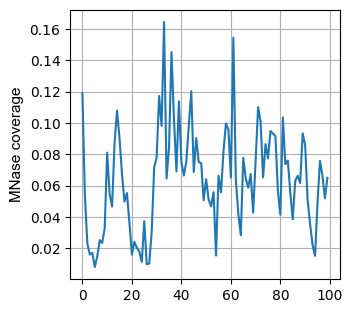

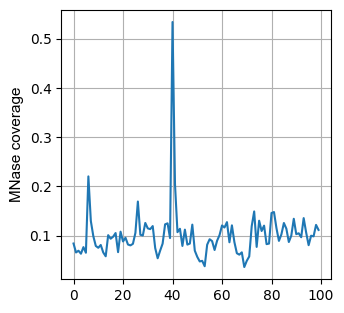

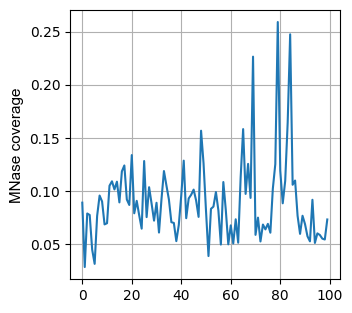

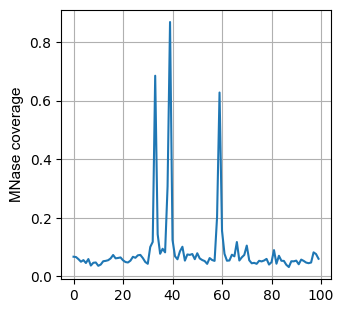

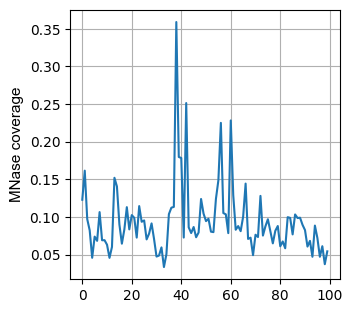

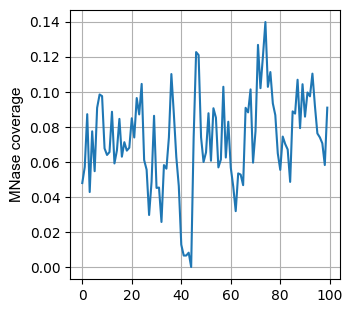

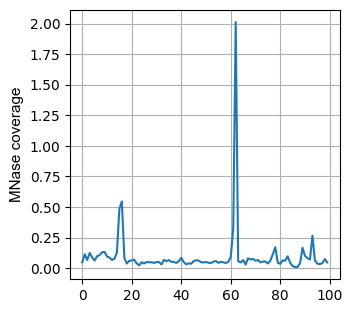

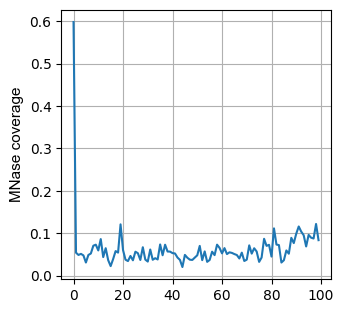

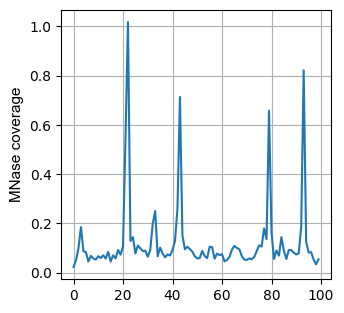

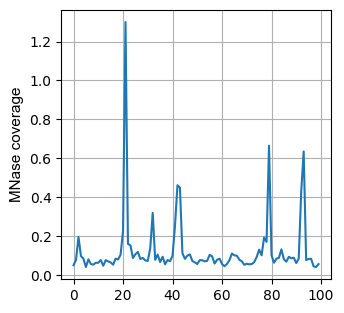

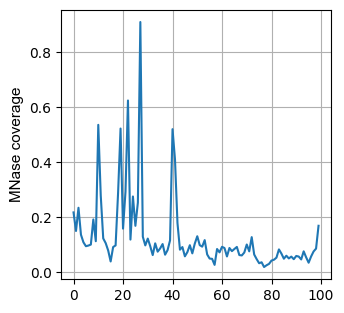

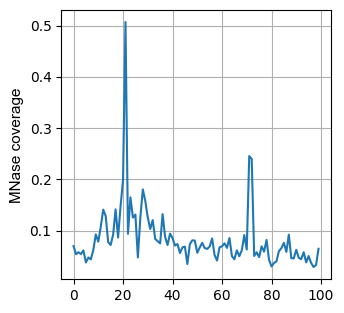

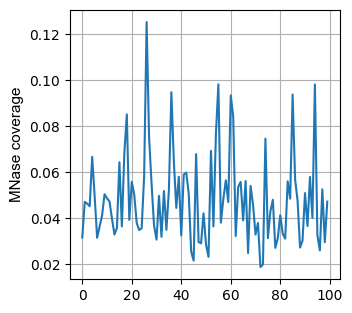

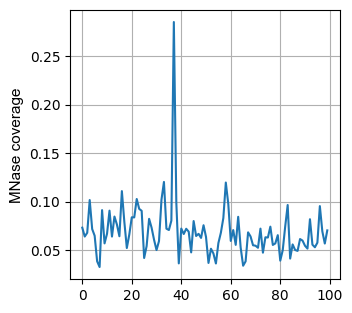

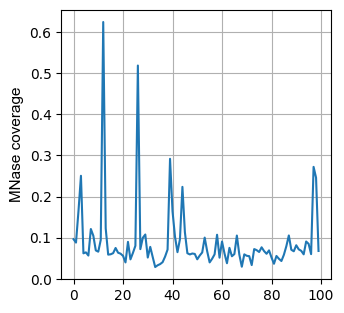

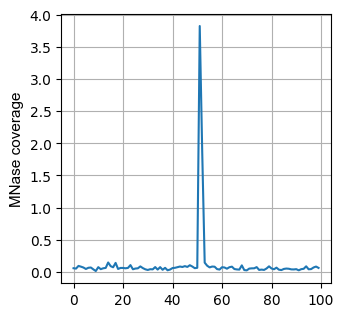

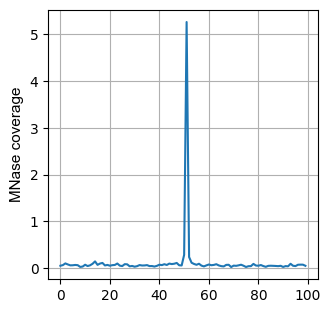

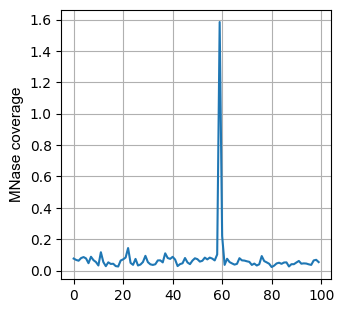

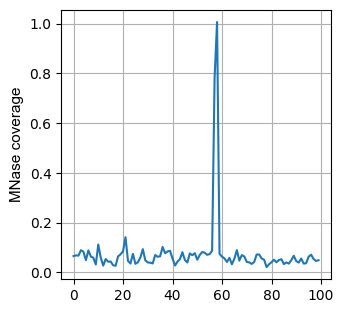

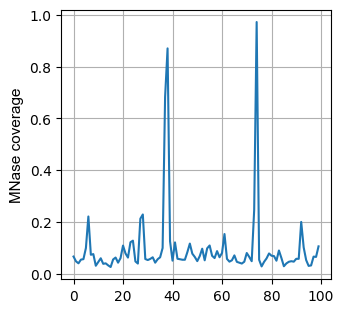

In [117]:
for i in range(20):

    fig=plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)
    #ax1.errorbar(f_mean_MNase_TE_and_Ctr_1["MNase"].values[i],f_mean_MNase_TE_and_Ctr_1["MNase"].values[i])
    ax1.errorbar(np.arange(0,len(f_mean_MNase_TE_and_Ctr_1["MNase"].values[i])) ,f_mean_MNase_TE_and_Ctr_1["MNase"].values[i]   )    
    #plt.yticks(fontname = "Arial",fontsize=11) 
    #plt.xticks(x_pos,["L1HS elements","Uniform insertions"],fontname = "Arial",fontsize=11) 
    #plt.ylabel("Fraction of ENCODE/OpenChrom \nregions in proximity to element",fontname = "Arial",fontsize=11)
    #plt.ylabel("Fraction of elements in proximity to \nENCODE/OpenChrom regions",fontname = "Arial",fontsize=11)
    plt.ylabel("MNase coverage",fontname = "Arial",fontsize=11)
    
    #plt.legend(prop={'family': 'Arial','size': 11},loc="upper left")
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(1,np.max(dist_x_list[i]))
    #plt.xlim(1,1000)
    #print(np.max(dist_x_list[i]))
    #plt.legend(prop={'family': 'Arial','size': 11})
    plt.grid()
    ax1.set_aspect(1./ax1.get_data_ratio())

<ErrorbarContainer object of 3 artists>

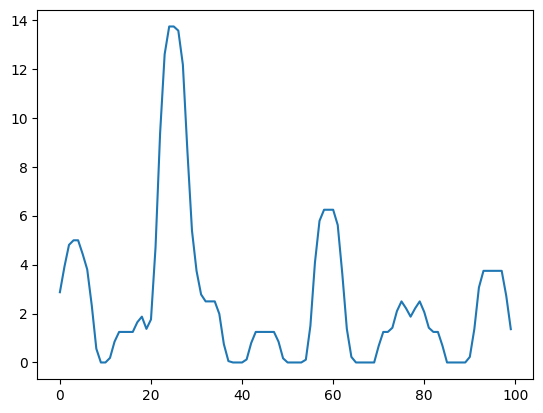

In [104]:
plt.errorbar(np.arange(0,len(f_mean_MNase_TE_and_Ctr_1["MNase"].values[0])) ,f_mean_MNase_TE_and_Ctr_1["MNase"].values[0]   )

In [15]:
mean_MNase_rmd_1["MNase"].values

array([0.695016703822396, 4.1603476700031, 2.775915345659277, ...,
       array([-1.]), array([-1.]), array([-1.])], dtype=object)

In [26]:
mean_MNase_rmd_1

ID   Name   Chr  Signal start  Signal stop Orientation     MNase
0   L1ME1  L1ME1  chr1     117440426    117440514        chr1  0.695017
1   L1ME1  L1ME1  chr1     117440494    117441457        chr1  4.160348
2   L1ME1  L1ME1  chr1     114294558    114295009        chr1  2.775915
3   L1ME1  L1ME1  chr1     116391804    116391994        chr1  7.292076
4   L1ME1  L1ME1  chr1     216004377    216007947        chr1  4.023900
5   L1ME1  L1ME1  chr1      14417628     14418035        chr1  5.153985
6   L1ME1  L1ME1  chr1      76021500     76021846        chr1  3.405475
7   L1ME1  L1ME1  chr1      93453441     93454616        chr1  3.490960
8   L1ME1  L1ME1  chr1     101449662    101450919        chr1  2.667030
9   L1ME1  L1ME1  chr1     112065436    112066641        chr1  3.289270
10  L1ME1  L1ME1  chr1     179567423    179568867        chr1  4.316536
11  L1ME1  L1ME1  chr1     230293028    230293752        chr1  8.653048
12  L1ME1  L1ME1  chr1     239337172    239337674        chr1  2.628633
13  L1ME1  L1ME1  chr1        441800       441950        chr1  0.000000
14  L1ME1  L1ME1  chr1        442111       442654        chr1  0.000000
15  L1ME1  L1ME1  chr1        540065       540810        chr1  0.010949
16  L1ME1  L1ME1  chr1        540958       541132        chr1  0.000000
17  L1ME1  L1ME1  chr1        920202       920240        chr1  3.416108
18  L1ME1  L1ME1  chr1        920552       920979        chr1  7.611123
19  L1ME1  L1ME1  chr1        921825       922155        chr1  4.103908

In [23]:
test_MNase=bw_MNase_HeLa.stats("chr1",117440426 ,117440514,type="mean",nBins=1)

In [24]:
print(test_MNase)

[0.695016703822396]
